![uc3m logo](https://assets.onthehub.com/attachments/15/401d138e-5b75-de11-b7f9-0030487d8896/3d13020c-f96c-4a26-8c47-b617961e9c81.jpg)

# AA2024 - PRÁCTICA 2 - CLUSTERING - DETERMINACIÓN DE TIPOS DE ESTRELLAS

**Github:** https://github.com/rosareyes/AA24-100434072-P2

---

**Alumna:**

Rosa Reyes - 100434072


**Objetivo de la práctica:** obtener los tipos de estrellas utilizando técnicas de
aprendizaje automático no supervisado.


## Preparación de los Datos




In [ ]:
# Imports de librerías

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from matplotlib import style
from sklearn.metrics import pairwise_distances_argmin
import time
from sklearn.preprocessing import StandardScaler
from numpy.random import uniform
import random
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import OrdinalEncoder
import warnings

style.use('ggplot') or plt.style.use('ggplot')
warnings.filterwarnings('ignore')



In [ ]:
stars_data = pd.read_csv('stars_data.csv')

# Mostrar las primeras filas del DataFrame para obtener una vista previa de los datos
print("Primeras filas del dataset:")
print(stars_data.head())

# Para cada columna categórica en el DataFrame, imprimir los valores únicos
for column in stars_data.select_dtypes(include='object').columns:
    print(f"\nValores únicos en '{column}': {stars_data[column].unique()}\n")

Primeras filas del dataset:
   Temperature         L       R    A_M Color Spectral_Class
0         3068  0.002400  0.1700  16.12   Red              M
1         3042  0.000500  0.1542  16.60   Red              M
2         2600  0.000300  0.1020  18.70   Red              M
3         2800  0.000200  0.1600  16.65   Red              M
4         1939  0.000138  0.1030  20.06   Red              M

Valores únicos en 'Color': ['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'yellowish' 'Yellowish' 'Orange-Red'
 'Blue-White']


Valores únicos en 'Spectral_Class': ['M' 'B' 'A' 'F' 'O' 'K' 'G']



Debemos normalizar la columna de Color, ya que tiene como podemos ver valores muy parecidos pero escritos de manera distinta. Aun así, hay algunos que son obvios, como Blue White escrito de maneras distintas, pero debemos analizar los demás, como por ejemplo, Orange-Red, Whitish, para saber si es posible juntarlas con otras clases o si tiene sentido que fuesen una clase independiente.


In [ ]:
# Ver la relación entre 'Color' y 'Spectral_Class'
color_spectral_class = pd.crosstab(stars_data['Color'], stars_data['Spectral_Class'])
print(color_spectral_class)

Spectral_Class      A   B  F  G  K    M   O
Color                                      
Blue                0  16  0  0  0    0  40
Blue White          1   9  0  0  0    0   0
Blue white          2   2  0  0  0    0   0
Blue-White          1   0  0  0  0    0   0
Blue-white          8  18  0  0  0    0   0
Orange              0   0  0  0  1    1   0
Orange-Red          0   0  0  0  1    0   0
Pale yellow orange  0   0  1  0  0    0   0
Red                 0   0  0  1  1  110   0
White               5   0  2  0  0    0   0
White-Yellow        0   0  1  0  0    0   0
Whitish             1   1  0  0  0    0   0
Yellowish           0   0  0  0  1    0   0
Yellowish White     0   0  3  0  0    0   0
white               1   0  2  0  0    0   0
yellow-white        0   0  8  0  0    0   0
yellowish           0   0  0  0  2    0   0


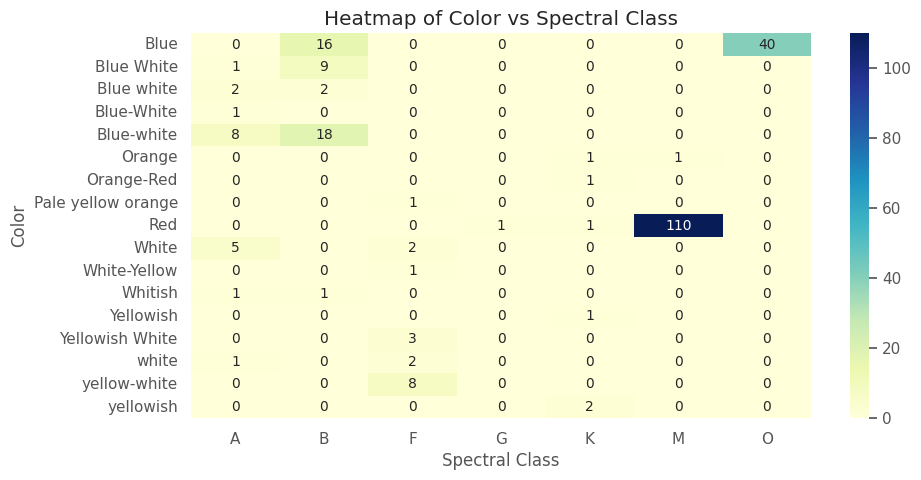

In [ ]:
# hacemos un heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(color_spectral_class, annot=True, cmap="YlGnBu", fmt="d")
plt.title('Heatmap of Color vs Spectral Class')
plt.xlabel('Spectral Class')
plt.ylabel('Color')
plt.show()

Unificamos ahora los colores, de acuerdo al Star Color Unifier notebook de AG, y además, con la seguridad de que es correcto gracias al heatmap anterior, viendo la clase espectral de cada color.





In [ ]:
# Establecemos una unificación de colores:
mapping = {   # Diccionario con formato Target : List of current values
    'Red': ['Red'],
    'Orange-Red': ['Orange-Red'],
    'Orange': ['Orange'],
    'Yellow-Orange': ['Pale yellow orange'],
    'Yellow': ['yellowish', 'Yellowish'],
    'White-Yellow': ['Yellowish White', 'yellow-white', 'White-Yellow'],
    'White': ['White', 'Whitish', 'white'],
    'Blue-White': ['Blue White', 'Blue white', 'Blue-white', 'Blue-White'],
    'Blue': ['Blue'],
}

# Mapeamos los datos
for target_color, source_colors in mapping.items():
  stars_data.loc[stars_data.Color.isin(source_colors), 'Color'] = target_color
stars_data

# Verificar los cambios
print(stars_data['Color'].unique())


# y también vemos la relación con las clases espectrales con este nuevo mapeo
updated_color_counts = stars_data['Color'].value_counts()
updated_color_spectral_class_distribution = pd.crosstab(stars_data['Color'], stars_data['Spectral_Class'])

updated_color_counts
print('\n(O, B, A, F, G,K, M) | más calientes O -> más frías M\n')

# Secuencia de clases espectrales de más caliente a más fría: O, B, A, F, G, K, M
spectral_order = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
row_order = ['Blue', 'Blue-White', 'White', 'White-Yellow', 'Yellow', 'Yellow-Orange', 'Orange', 'Orange-Red', 'Red']
updated_spectral_distribution = updated_color_spectral_class_distribution[spectral_order].reindex(row_order)

updated_spectral_distribution


['Red' 'Blue-White' 'White' 'White-Yellow' 'Yellow-Orange' 'Blue' 'Orange'
 'Yellow' 'Orange-Red']

(O, B, A, F, G,K, M) | más calientes O -> más frías M



Spectral_Class   O   B   A   F  G  K    M
Color                                    
Blue            40  16   0   0  0  0    0
Blue-White       0  29  12   0  0  0    0
White            0   1   7   4  0  0    0
White-Yellow     0   0   0  12  0  0    0
Yellow           0   0   0   0  0  3    0
Yellow-Orange    0   0   0   1  0  0    0
Orange           0   0   0   0  0  1    1
Orange-Red       0   0   0   0  0  1    0
Red              0   0   0   0  1  1  110

In [ ]:
# Información general del DataFrame, incluyendo el tipo de datos y los valores nulos
print("\nInformación del DataFrame:")
stars_data.info()

# Descripción estadística de las variables numéricas
print("\nEstadísticas descriptivas de las variables numéricas:")
print(stars_data.describe())

# Descripción estadística de las variables categóricas
print("\nEstadísticas descriptivas de las variables categóricas:")
print(stars_data.describe(include=['object']))

# Verificación de valores nulos
print("\nVerificación de valores nulos en el dataset:")
print(stars_data.isnull().sum())


Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 11.4+ KB

Estadísticas descriptivas de las variables numéricas:
        Temperature              L            R         A_M
count    240.000000     240.000000   240.000000  240.000000
mean   10497.462500  107188.361635   237.157781    4.382396
std     9552.425037  179432.244940   517.155763   10.532512
min     1939.000000       0.000080     0.008400  -11.920000
25%     3344.250000       0.000865     0.102750   -6.232500
50%     5776.000000       0.07

- El conjunto de datos contiene 240 entradas.
- Hay seis columnas: Temperature, L (Luminosidad), R (Radio), A_M (Magnitud Absoluta), Color y Spectral_Class.
- Todos los valores están completos en el dataset; no hay valores nulos en ninguna columna.

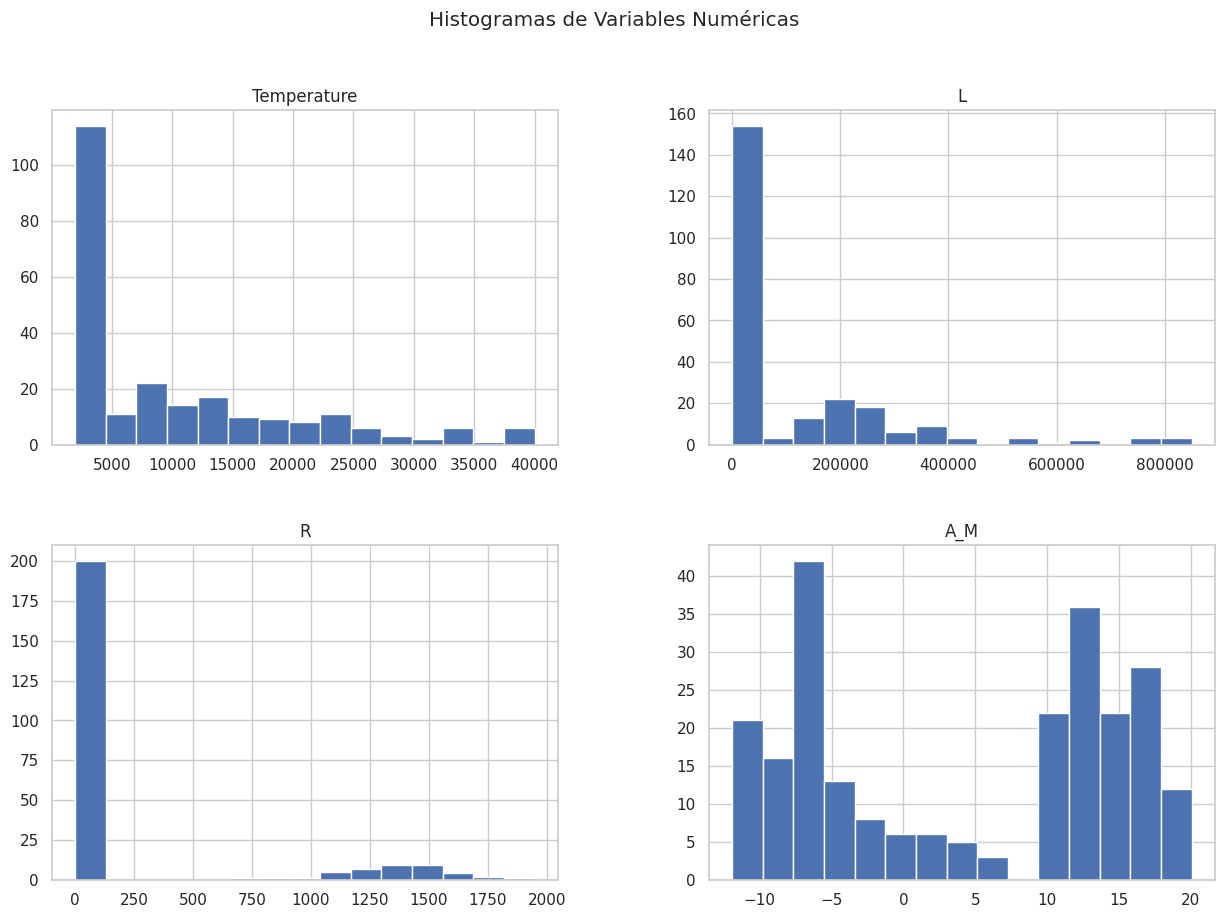

In [ ]:
# Configuración de visualización
sns.set(style="whitegrid")

# Histogramas para variables numéricas
stars_data[['Temperature', 'L', 'R', 'A_M']].hist(bins=15, figsize=(15, 10), layout=(2, 2))
plt.suptitle('Histogramas de Variables Numéricas')
plt.show()

Con estas gráficas podemos ver ciertas características del conjunto de datos interesantes:

**Temperatura (Temperature):** La mayoría de las estrellas tienen temperaturas por debajo de 10,000 K, con un pico significativo en el extremo inferior del rango.
La distribución muestra que las estrellas frías son mucho más comunes que las calientes

**Luminosidad (L):** Hay un pico extremadamente alto para luminosidades bajas, lo que sugiere que las estrellas con baja luminosidad son muy comunes.
Existen algunas estrellas con luminosidades mucho más altas, pero son mucho menos frecuentes.

**Radio (R):** Similar a la luminosidad, hay un pico alto para radios pequeños, indicando que la mayoría de las estrellas tienen radios relativamente pequeños comparados con el Sol.

Existe una larga cola hacia radios más grandes, lo que indica que hay unas pocas estrellas con radios mucho más grandes que la mayoría.




## Comparación K-Means de Scikit-learn e implementación propia



In [ ]:
# Simulación de datos
X, y = make_blobs(
    n_samples    = 300,
    n_features   = 2,
    centers      = 4,
    cluster_std  = 0.60,
    shuffle      = True,
    random_state = 100434072
)

k = 4  # Número de clusters deseado

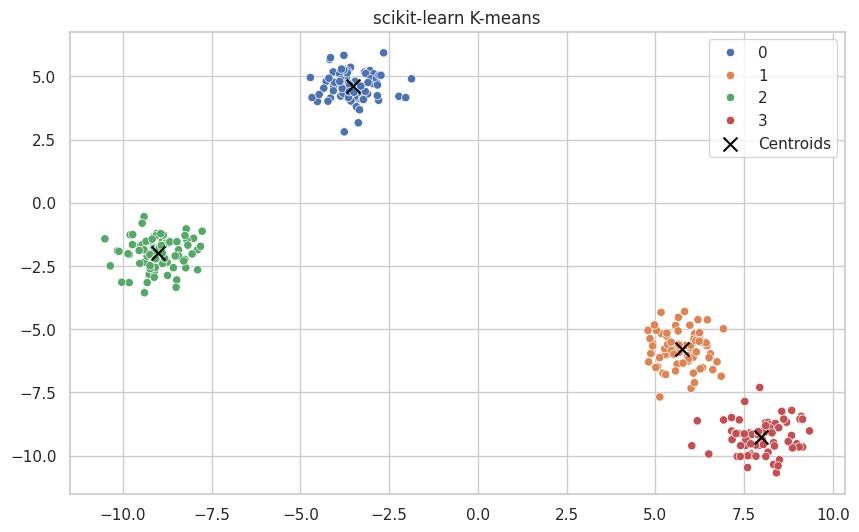

In [ ]:
# scikit-learn K-Means
# Medir el tiempo
start_time_sklearn = time.time()
kmeans_sklearn = KMeans(n_clusters=k, random_state=100434072).fit(X)
elapsed_time_sklearn = time.time() - start_time_sklearn

# Calcular la puntuación de silueta para la implementación de scikit-learn
silhouette_score_sklearn = silhouette_score(X, kmeans_sklearn.labels_)

centroids = kmeans_sklearn.cluster_centers_
classification = kmeans_sklearn.labels_

# Generamos la visualización
plt.figure(figsize=(10, 6))  # Ajustamos el tamaño para una mejor visualización
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=classification, palette="deep")
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=100, label='Centroids')
plt.title("scikit-learn K-means")
plt.legend()
plt.show()


Ahora, se crea una implementación propia del Kmeans, a través de una clase y métodos auxiliares.

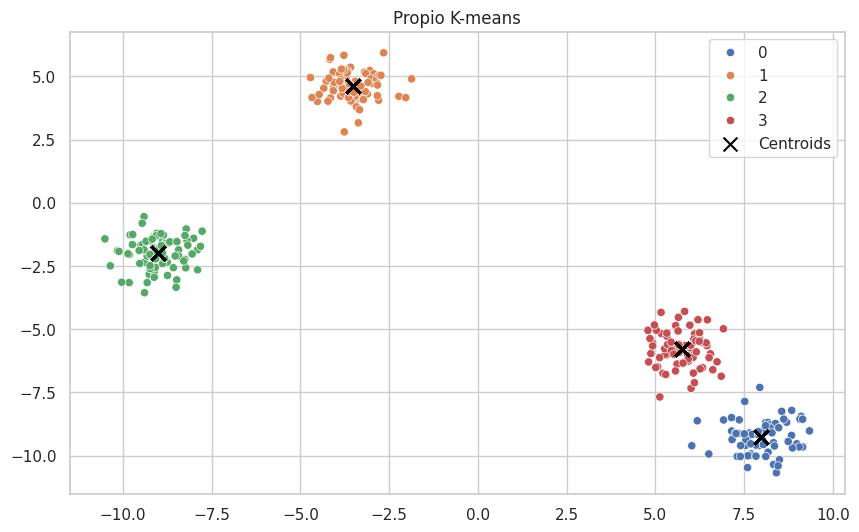

In [ ]:
def most_common(lst):
    """
    Devuelve el elemento más frecuente en una lista.
    """
    return max(set(lst), key=lst.count)


def euclidean(point, data):
    """
    Devuelve la distancia euclidiana entre un punto y un dataset
    """
    return np.sqrt(np.sum((point - data)**2, axis=1))


class CustomKMeans:

    def __init__(self, n_clusters=8, max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, X_train):

        # Initialize the centroids, using the "k-means++" method, where a random datapoint is selected as the first,
        # then the rest are initialized w/ probabilities proportional to their distances to the first
        # Pick a random point from train data for first centroid
        self.centroids = [random.choice(X_train)]

        for _ in range(self.n_clusters-1):
            # Calculate distances from points to the centroids
            dists = np.sum([euclidean(centroid, X_train) for centroid in self.centroids], axis=0)
            # Normalize the distances
            dists /= np.sum(dists)
            # Choose remaining points based on their distances
            new_centroid_idx = np.random.choice(range(len(X_train)), size=1, p=dists)[0]  # Indexed @ zero to get val, not array of val
            self.centroids += [X_train[new_centroid_idx]]

        # Iterate, adjusting centroids until converged or until passed max_iter
        iteration = 0
        prev_centroids = None
        while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
            # Sort each datapoint, assigning to nearest centroid
            sorted_points = [[] for _ in range(self.n_clusters)]
            for x in X_train:
                dists = euclidean(x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)

            # Push current centroids to previous, reassign centroids as mean of the points belonging to them
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                    self.centroids[i] = prev_centroids[i]
            iteration += 1

    def evaluate(self, X):
        centroids = []
        centroid_idxs = []
        for x in X:
            dists = euclidean(x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroids.append(self.centroids[centroid_idx])
            centroid_idxs.append(centroid_idx)

        return centroids, centroid_idxs


# Fit centroids to dataset
start_time_custom = time.time()
kmeans_propio = CustomKMeans(n_clusters=k)
kmeans_propio.fit(X)
elapsed_time_custom = time.time() - start_time_custom

centroids, classification = kmeans_propio.evaluate(X)

silhouette_score_custom = silhouette_score(X, classification)

# Convertimos la clasificación y los centroides en arrays de np
classification = np.array(classification)
centroids = np.array(centroids)

# Generamos la visualización
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=classification, palette="deep")
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=100, label='Centroids')
plt.title("Propio K-means")
plt.legend()
plt.show()

Ahora comparamos el tiempo de ejecución de cada una de las implementaciones y el silhouette score

In [ ]:
print(f"Tiempo de ejecución scikit-learn: {elapsed_time_sklearn} segundos")
print(f"Puntuación de silueta scikit-learn: {silhouette_score_sklearn}")

print(f"Tiempo de ejecución personalizado: {elapsed_time_custom} segundos")
print(f"Puntuación de silueta personalizada: {silhouette_score_custom}")

Tiempo de ejecución scikit-learn: 0.02034282684326172 segundos
Puntuación de silueta scikit-learn: 0.8026761202191619
Tiempo de ejecución personalizado: 0.008684635162353516 segundos
Puntuación de silueta personalizada: 0.8026761202191619


> **¿Qué es la puntuación de la silueta?**

> La puntuación de silueta es un valor numérico entre -1 y 1 que indica el grado de pertenencia de un punto de datos a su clúster y su separación de otros clústeres. Una puntuación de silueta alta significa que el punto de datos está cerca de la distancia media de su clúster y lejos del clúster vecino más cercano, lo que implica una buena agrupación en clústeres.

Podemos ver que la puntuación de las siluetas tanto del kmeans de scikit-learn y el custom que hemos implementado son iguales.

Además, con la definición de arriba, podemos ver que es de 0.8026, un valor muy cercano a 1, y por lo tanto, implica que tenemos una buena agrupación en los clústeres.

En el tiempo de ejecución, es importante destacar que el KMeans de scikit-learn es más rápido, lo cual es lo esperado.

Por lo tanto, la implementación desde 0 del KMeans ha sido efectiva, pero no es más rápida que la de Scikit-learn debido a que esta librería está claramente optimizada, versus el método implementado en python puro.

## One Hot Encoding

Ahora procedemos a codificar nuestros datos con el One Hot Encoding y posteriormente a implementar tres algoritmos de ML para definir el número de clústers.

In [ ]:
stars_data_ohe = pd.get_dummies(stars_data)
stars_data_ohe.head()

Temperature         L       R    A_M  Color_Blue  Color_Blue-White  \
0         3068  0.002400  0.1700  16.12       False             False   
1         3042  0.000500  0.1542  16.60       False             False   
2         2600  0.000300  0.1020  18.70       False             False   
3         2800  0.000200  0.1600  16.65       False             False   
4         1939  0.000138  0.1030  20.06       False             False   

   Color_Orange  Color_Orange-Red  Color_Red  Color_White  Color_White-Yellow  \
0         False             False       True        False               False   
1         False             False       True        False               False   
2         False             False       True        False               False   
3         False             False       True        False               False   
4         False             False       True        False               False   

   Color_Yellow  Color_Yellow-Orange  Spectral_Class_A  Spectral_Class_B  \
0         False                False             False             False   
1         False                False             False             False   
2         False                False             False             False   
3         False                False             False             False   
4         False                False             False             False   

   Spectral_Class_F  Spectral_Class_G  Spectral_Class_K  Spectral_Class_M  \
0             False             False             False              True   
1             False             False             False              True   
2             False             False             False              True   
3             False             False             False              True   
4             False             False             False              True   

   Spectral_Class_O  
0             False  
1             False  
2             False  
3             False  
4             False

### Escalado, PCA y TSNE de los datos

Escalamos nuestros datos y luego hacemos un PCA para reducir la dimensionalidad de los datos a dos.

Además, como un extra para la práctica, he implementado otro método para reducir la dimensionalidad, llamado t-SNE, que según algunos profesores, podría mostrar una mejor agrupación de los datos.

In [ ]:
# Escalado primero
datos_escalados_ohe = scale(stars_data_ohe)

# PCA
pca = PCA(n_components=2)
stars_pca_ohe = pca.fit_transform(datos_escalados_ohe)
pd.DataFrame(stars_pca_ohe)

0         1
0   -2.273159  0.371693
1   -2.288643  0.360410
2   -2.370841  0.313063
3   -2.300798  0.360701
4   -2.440581  0.284710
..        ...       ...
235  4.342502  2.167716
236  4.727361  3.033502
237  1.718377 -0.014074
238  1.478364 -0.454191
239  4.178973  2.228079

[240 rows x 2 columns]

In [ ]:
# TSNE

# Apply t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=100434072)
stars_tsne_ohe = tsne.fit_transform(datos_escalados_ohe)

stars_tsne_ohe

array([[-1.11777544e+01, -6.34658957e+00],
       [-1.17959032e+01, -6.73940277e+00],
       [-1.43353863e+01, -8.41182232e+00],
       [-1.15850048e+01, -7.31930351e+00],
       [-1.51822052e+01, -8.83618069e+00],
       [-1.21673460e+01, -7.56487274e+00],
       [-1.24604797e+01, -7.93345499e+00],
       [-1.27752819e+01, -8.03665543e+00],
       [-1.28863878e+01, -7.97990465e+00],
       [-1.08750114e+01, -6.70907974e+00],
       [-4.16919470e+00, -8.53457272e-01],
       [-5.31327438e+00, -1.27270949e+00],
       [-6.48686743e+00, -2.60583544e+00],
       [-4.15575647e+00, -5.86129487e-01],
       [-5.57069397e+00, -1.01782477e+00],
       [-6.52322721e+00, -2.25884533e+00],
       [-8.01832676e+00, -4.14086151e+00],
       [-4.14153767e+00, -1.02732432e+00],
       [-6.89341879e+00, -2.84263396e+00],
       [-4.53357887e+00, -1.18108463e+00],
       [ 1.04704952e+01, -1.52994981e-02],
       [ 2.49122307e-01, -5.51815844e+00],
       [-2.04210687e+00, -6.75732183e+00],
       [ 2.

### OHE: KMeans

Aquí, añadimos el escalado y el PCA en el pipeline para el método Elbow y Silueta.

Al final, muestro una comparación de los clústers si lo hiciesemos con TSNE también.

#### KMeans: Método Elbow

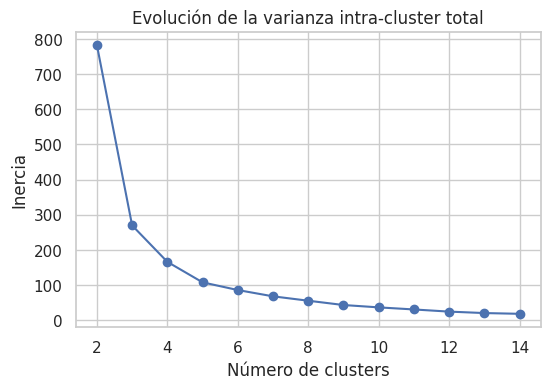

In [ ]:
# Método elbow para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
inertias = []

for n_clusters in range_n_clusters:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('kmeans', KMeans(n_clusters=n_clusters, n_init=20, random_state=100434072))
    ])
    # Ajustar el pipeline a los datos
    pipeline.fit(stars_data_ohe)
    # Obtener la inercia del paso kmeans
    inertias.append(pipeline.named_steps['kmeans'].inertia_)

# Graficar los resultados del método Elbow
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número de clusters')
ax.set_ylabel('Inercia')
plt.show()

 El gráfico muestra un descenso rápido y significativo en la inercia a medida que aumenta el número de clusters de 1 a 4. Esto sugiere que cada adición de un cluster en este rango reduce considerablemente la suma de las distancias al cuadrado dentro de los clusters, lo que mejora significativamente el ajuste del modelo a los datos.

 Entre 4 y 6 clusters, hay un cambio visible en la tasa de disminución de la inercia, donde la curva empieza a aplanarse. Esto es importante porque el método del codo busca identificar el punto en el cual aumentar el número de clusters deja de resultar en mejoras significativas en la inercia.

A partir de 6 clusters en adelante, la curva se vuelve bastante plana, indicando que aumentos adicionales en el número de clusters no resultan en una mejora significativa en la inercia.

Basado en el gráfico del método del codo, **6 clusters parece ser el número óptimo para este conjunto de datos**. Elegir más de 6 clusters no proporcionaría mejoras significativas en la compactación de los clusters y podría llevar a un sobreajuste, donde se empiezan a crear clusters que no corresponden a estructuras reales en los datos.


#### KMeans: Método Silhouette

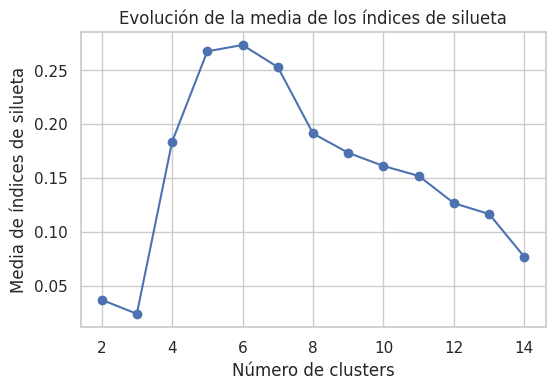

In [ ]:
# Método silhouette para identificar el número óptimo de clusters
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('kmeans', KMeans(n_clusters=n_clusters, n_init=20, random_state=100434072))
    ])
     # Ajustar el pipeline a los datos
    pipeline.fit_predict(stars_data_ohe)
    # Obtener las etiquetas de los clusters
    cluster_labels = pipeline.named_steps['kmeans'].labels_
    # Calcular la puntuación de silueta
    silhouette_avg = silhouette_score(stars_data_ohe, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

# Graficar los resultados de silueta
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de la media de los índices de silueta")
ax.set_xlabel('Número de clusters')
ax.set_ylabel('Media de índices de silueta')
plt.show()


La puntuación de silueta alcanza su punto más alto en **6 clusters**, indicando que este número de clusters muestra una buena separación y cohesión. Las puntuaciones bajas de silueta (0.28) sugieren que los clusters no están muy bien definidos y que la separación entre ellos no es muy clara.


#### KMeans: Comparación PCA vs. TSNE
Ahora, ya que sabemos que el número de clústers óptimo según Kmeans es 6, procedemos a hacer fit del KMeans tanto con el PCA como con TSNE, y así, comparamos como se distribuyen los clústers en ambas reducciones.

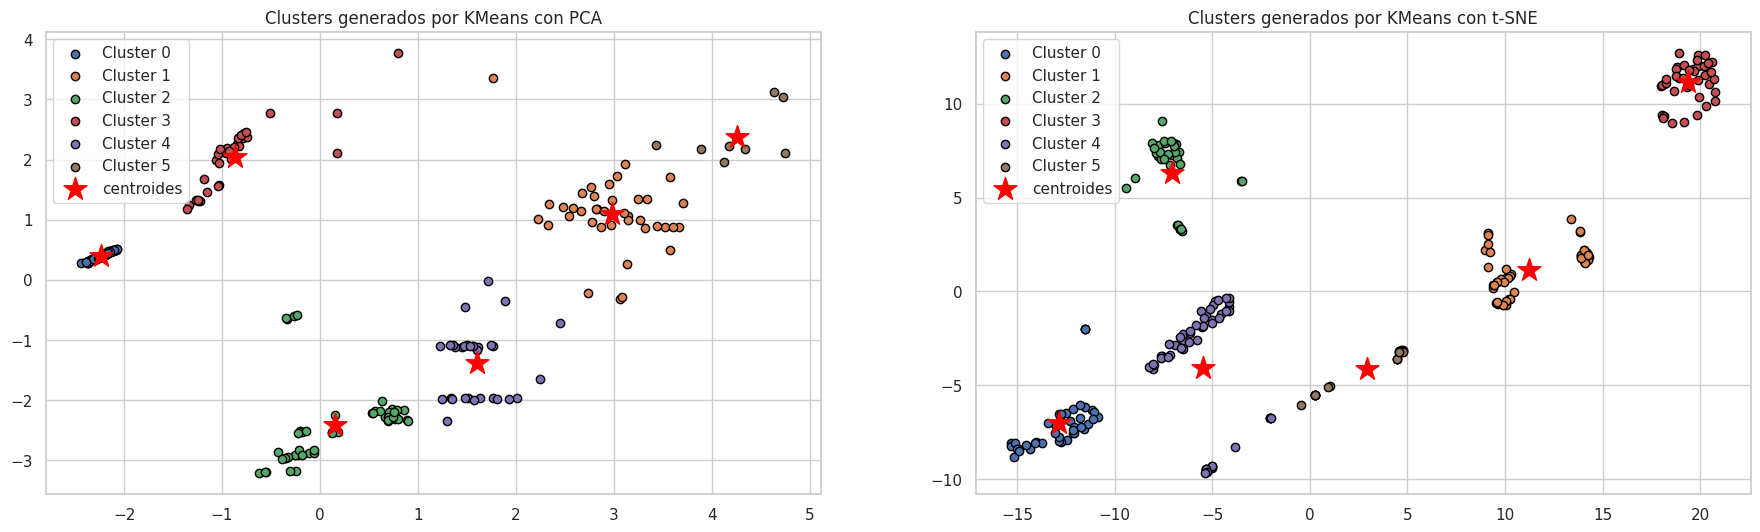

In [ ]:

# Ajustamos KMeans para PCA
modelo_kmeans_pca = KMeans(n_clusters=6, random_state=100434072)
modelo_kmeans_pca.fit(stars_pca_ohe)
y_predict_pca = modelo_kmeans_pca.predict(stars_pca_ohe)


# Ajustamos KMeans para TSNE
modelo_kmeans_tsne = KMeans(n_clusters=6, random_state=100434072)
modelo_kmeans_tsne.fit(stars_tsne_ohe)
y_predict_tsne = modelo_kmeans_tsne.predict(stars_tsne_ohe)

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))

# First subplot for PCA
for i in np.unique(y_predict_pca):
    ax1.scatter(
        x = stars_pca_ohe[y_predict_pca == i, 0],
        y = stars_pca_ohe[y_predict_pca == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax1.scatter(
    x = modelo_kmeans_pca.cluster_centers_[:, 0],
    y = modelo_kmeans_pca.cluster_centers_[:, 1],
    c='red',
    s = 300,
    marker = '*',
    label  = 'centroides'
)
ax1.set_title('Clusters generados por KMeans con PCA')
ax1.legend()

# Second subplot for t-SNE
for i in np.unique(y_predict_tsne):
    ax2.scatter(
        x = stars_tsne_ohe[y_predict_tsne == i, 0],
        y = stars_tsne_ohe[y_predict_tsne == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax2.scatter(
    x = modelo_kmeans_tsne.cluster_centers_[:, 0],
    y = modelo_kmeans_tsne.cluster_centers_[:, 1],
    c='red',
    s = 300,
    marker = '*',
    label  = 'centroides'
)
ax2.set_title('Clusters generados por KMeans con t-SNE')
ax2.legend()

plt.show()


Como podemos observar, con PCA, los clústers parecen más dispersos y menos definidos. En cambio, con TSNE, están mucho más compactos, y se puede visualizar mejor las agrupaciones de datos.

### OHE: Clúster Jerárquico

Para este método, intenté crear etiquetas para que semánticamente tuviese sentido la gráfica, pero al usar PCA, no tengo forma de hacerlo. Aún así, podemos ver los clústers sin importar las etiquetas en el eje X.

In [ ]:
def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''
    # Create linkage matrix and then plot the dendrogram
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Ajustar modelos de clustering jerárquico con diferentes tipos de linkage
modelo_hclust_complete = AgglomerativeClustering(
    metric='euclidean',
    linkage='complete',
    distance_threshold=0,
    n_clusters=None
)
modelo_hclust_complete.fit(X=stars_pca_ohe)

modelo_hclust_average = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'average',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_average.fit(X=stars_pca_ohe)

modelo_hclust_ward = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'ward',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_ward.fit(X=stars_pca_ohe)

AgglomerativeClustering(distance_threshold=0, metric='euclidean',
                        n_clusters=None)

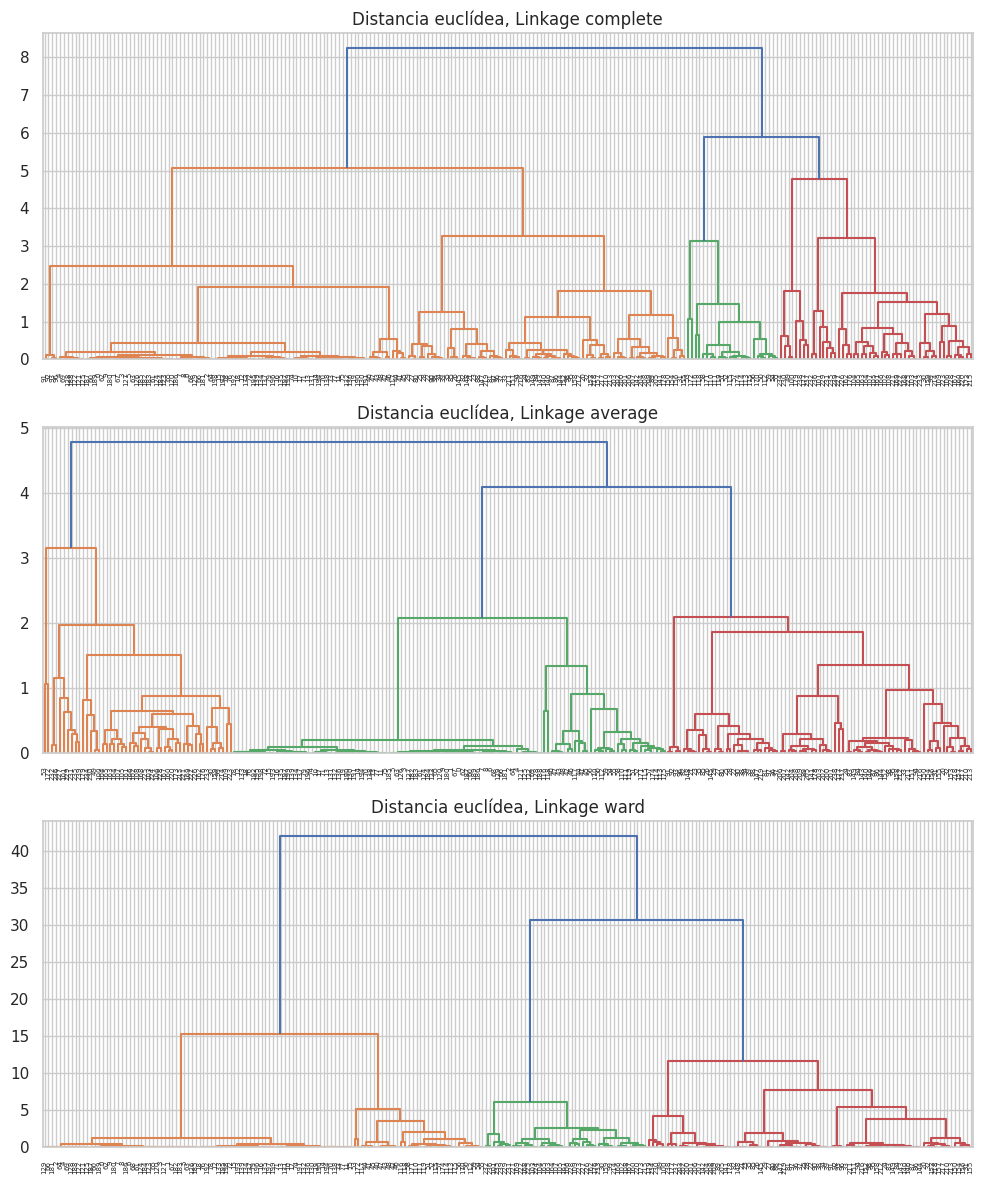

In [ ]:
# Dendrogramas
# ==============================================================================
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
plot_dendrogram(modelo_hclust_complete, labels=range(len(stars_pca_ohe)), ax=axs[0])
axs[0].set_title("Distancia euclídea, Linkage complete")
plot_dendrogram(modelo_hclust_average, labels=range(len(stars_pca_ohe)), ax=axs[1])
axs[1].set_title("Distancia euclídea, Linkage average")
plot_dendrogram(modelo_hclust_ward,  labels=range(len(stars_pca_ohe)), ax=axs[2])
axs[2].set_title("Distancia euclídea, Linkage ward")
plt.tight_layout()
plt.show()

Una vez ajustados los modelos de clustering jerárquico con diferentes tipos de linkage, podemos observar que el tercero, el ward, que minimiza la suma de diferencias cuadráticas dentro de los clústers, muestra una estructura más escalonada, y por lo tanto una integración más coherente de los clústers.

Por lo tanto, me quedaré con el **Linkage Ward** para el análisis y hacer la altura de corte.

En este caso, se puede ver perfectamente la agrupación de los clústers, y un corte entre 10 y 15 sería razonable.

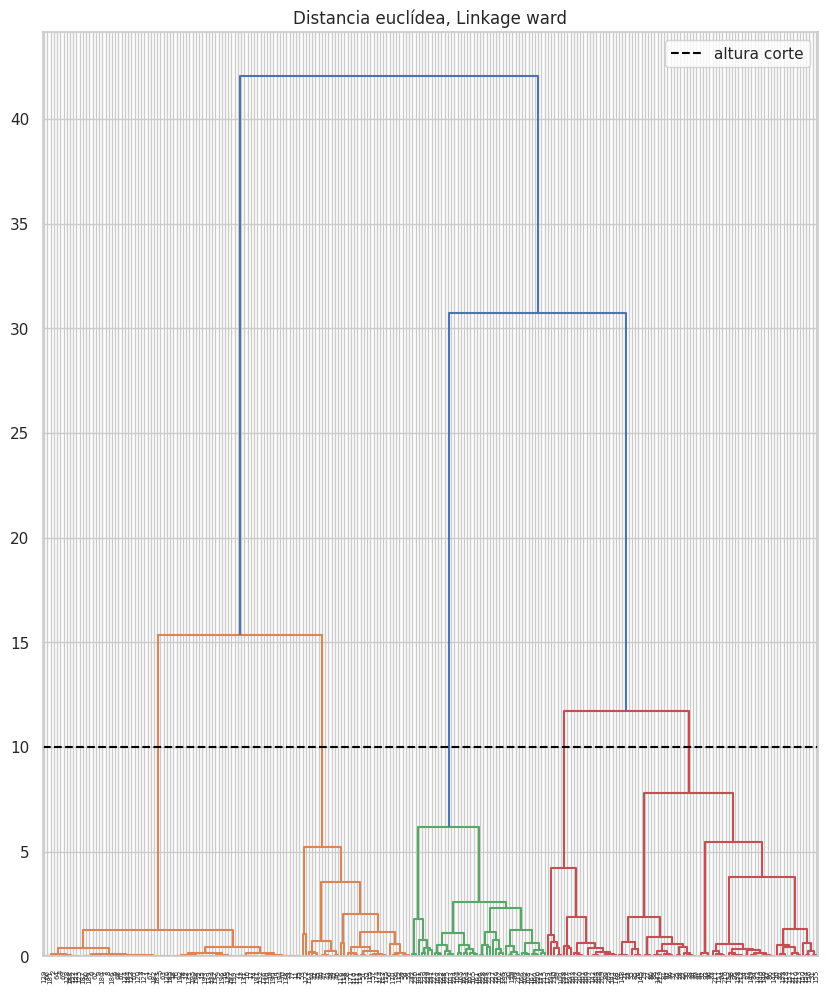

In [ ]:
# Ward
fig, ax = plt.subplots(1, 1, figsize=(10,12))
altura_corte_linkage_ward = 10
plot_dendrogram(modelo_hclust_ward,ax=ax,labels=range(len(stars_pca_ohe)))
ax.set_title("Distancia euclídea, Linkage ward")
ax.axhline(y=altura_corte_linkage_ward, c = 'black', linestyle='--', label='altura corte')
ax.legend();

#### Jerárquico: Método Silhouette

Hacemos nuevamente un pipeline, con el escaler y el PCA.

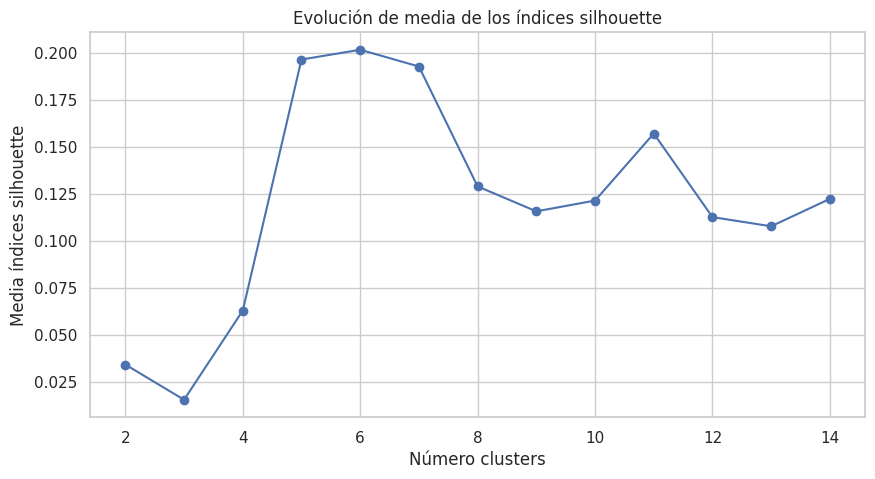

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('jerarquico', AgglomerativeClustering(
        affinity   = 'euclidean',
        linkage    = 'ward',
        n_clusters = n_clusters,
    ))
    ])

    cluster_labels = pipeline.fit_predict(stars_data_ohe)
    silhouette_avg = silhouette_score(stars_data_ohe, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

El indice sillhoutte alcanza su punto máximo en 6, con un puntaje de aproximadamente 0.20. Sigue siendo un índice bajo que nos indica que los clústers aún no están del todo bien separados.


### OHE: DBSCAN

Ahora haremos DBSCAN con PCA y TSNE para ver que reducción de la dimensionalidad de datos es más apropiada.

Empezamos viendo la nube de datos iniciales.

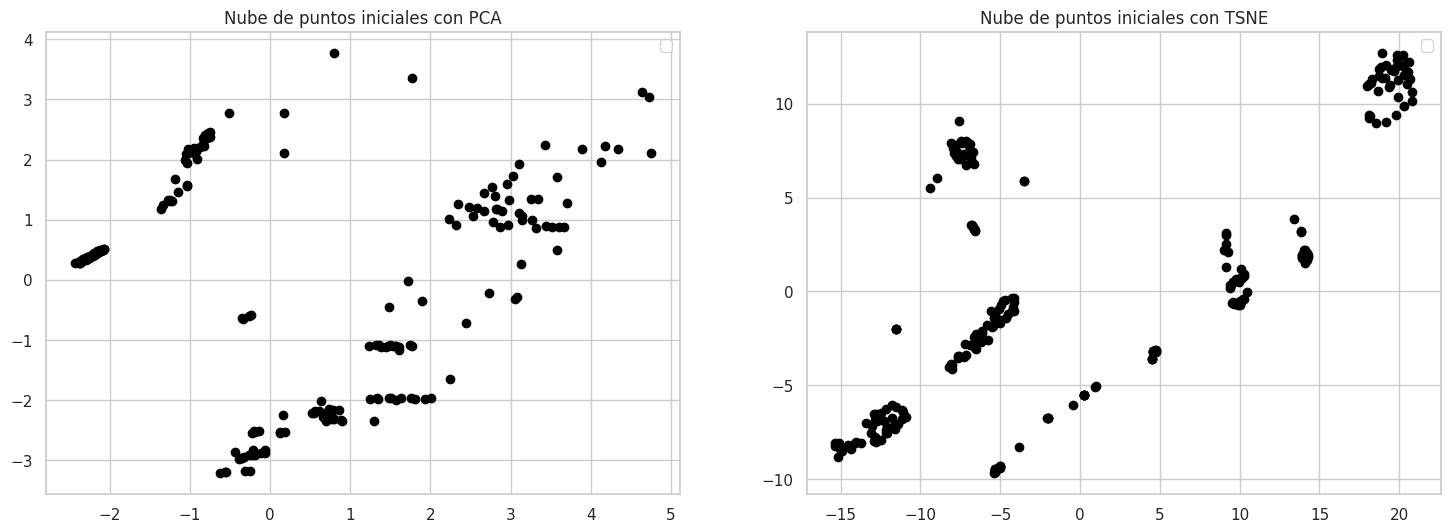

In [ ]:
# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.scatter(
    x = stars_pca_ohe[:, 0],
    y = stars_pca_ohe[:, 1],
    c = 'black',
    marker    = 'o',
    edgecolor = 'black'
)
ax1.legend()
ax1.set_title('Nube de puntos iniciales con PCA');

ax2.scatter(
    x = stars_tsne_ohe[:, 0],
    y = stars_tsne_ohe[:, 1],
    c = 'black',
    marker    = 'o',
    edgecolor = 'black'
)
ax2.legend()
ax2.set_title('Nube de puntos iniciales con TSNE');


#### BDSCAN: Buscando hiperparámetros con PCA

Ahora, haremos una comparativa con varios hiperparametros (eps y min samples) para ver cuál es el mejor ajuste (a ojo, graficamente).

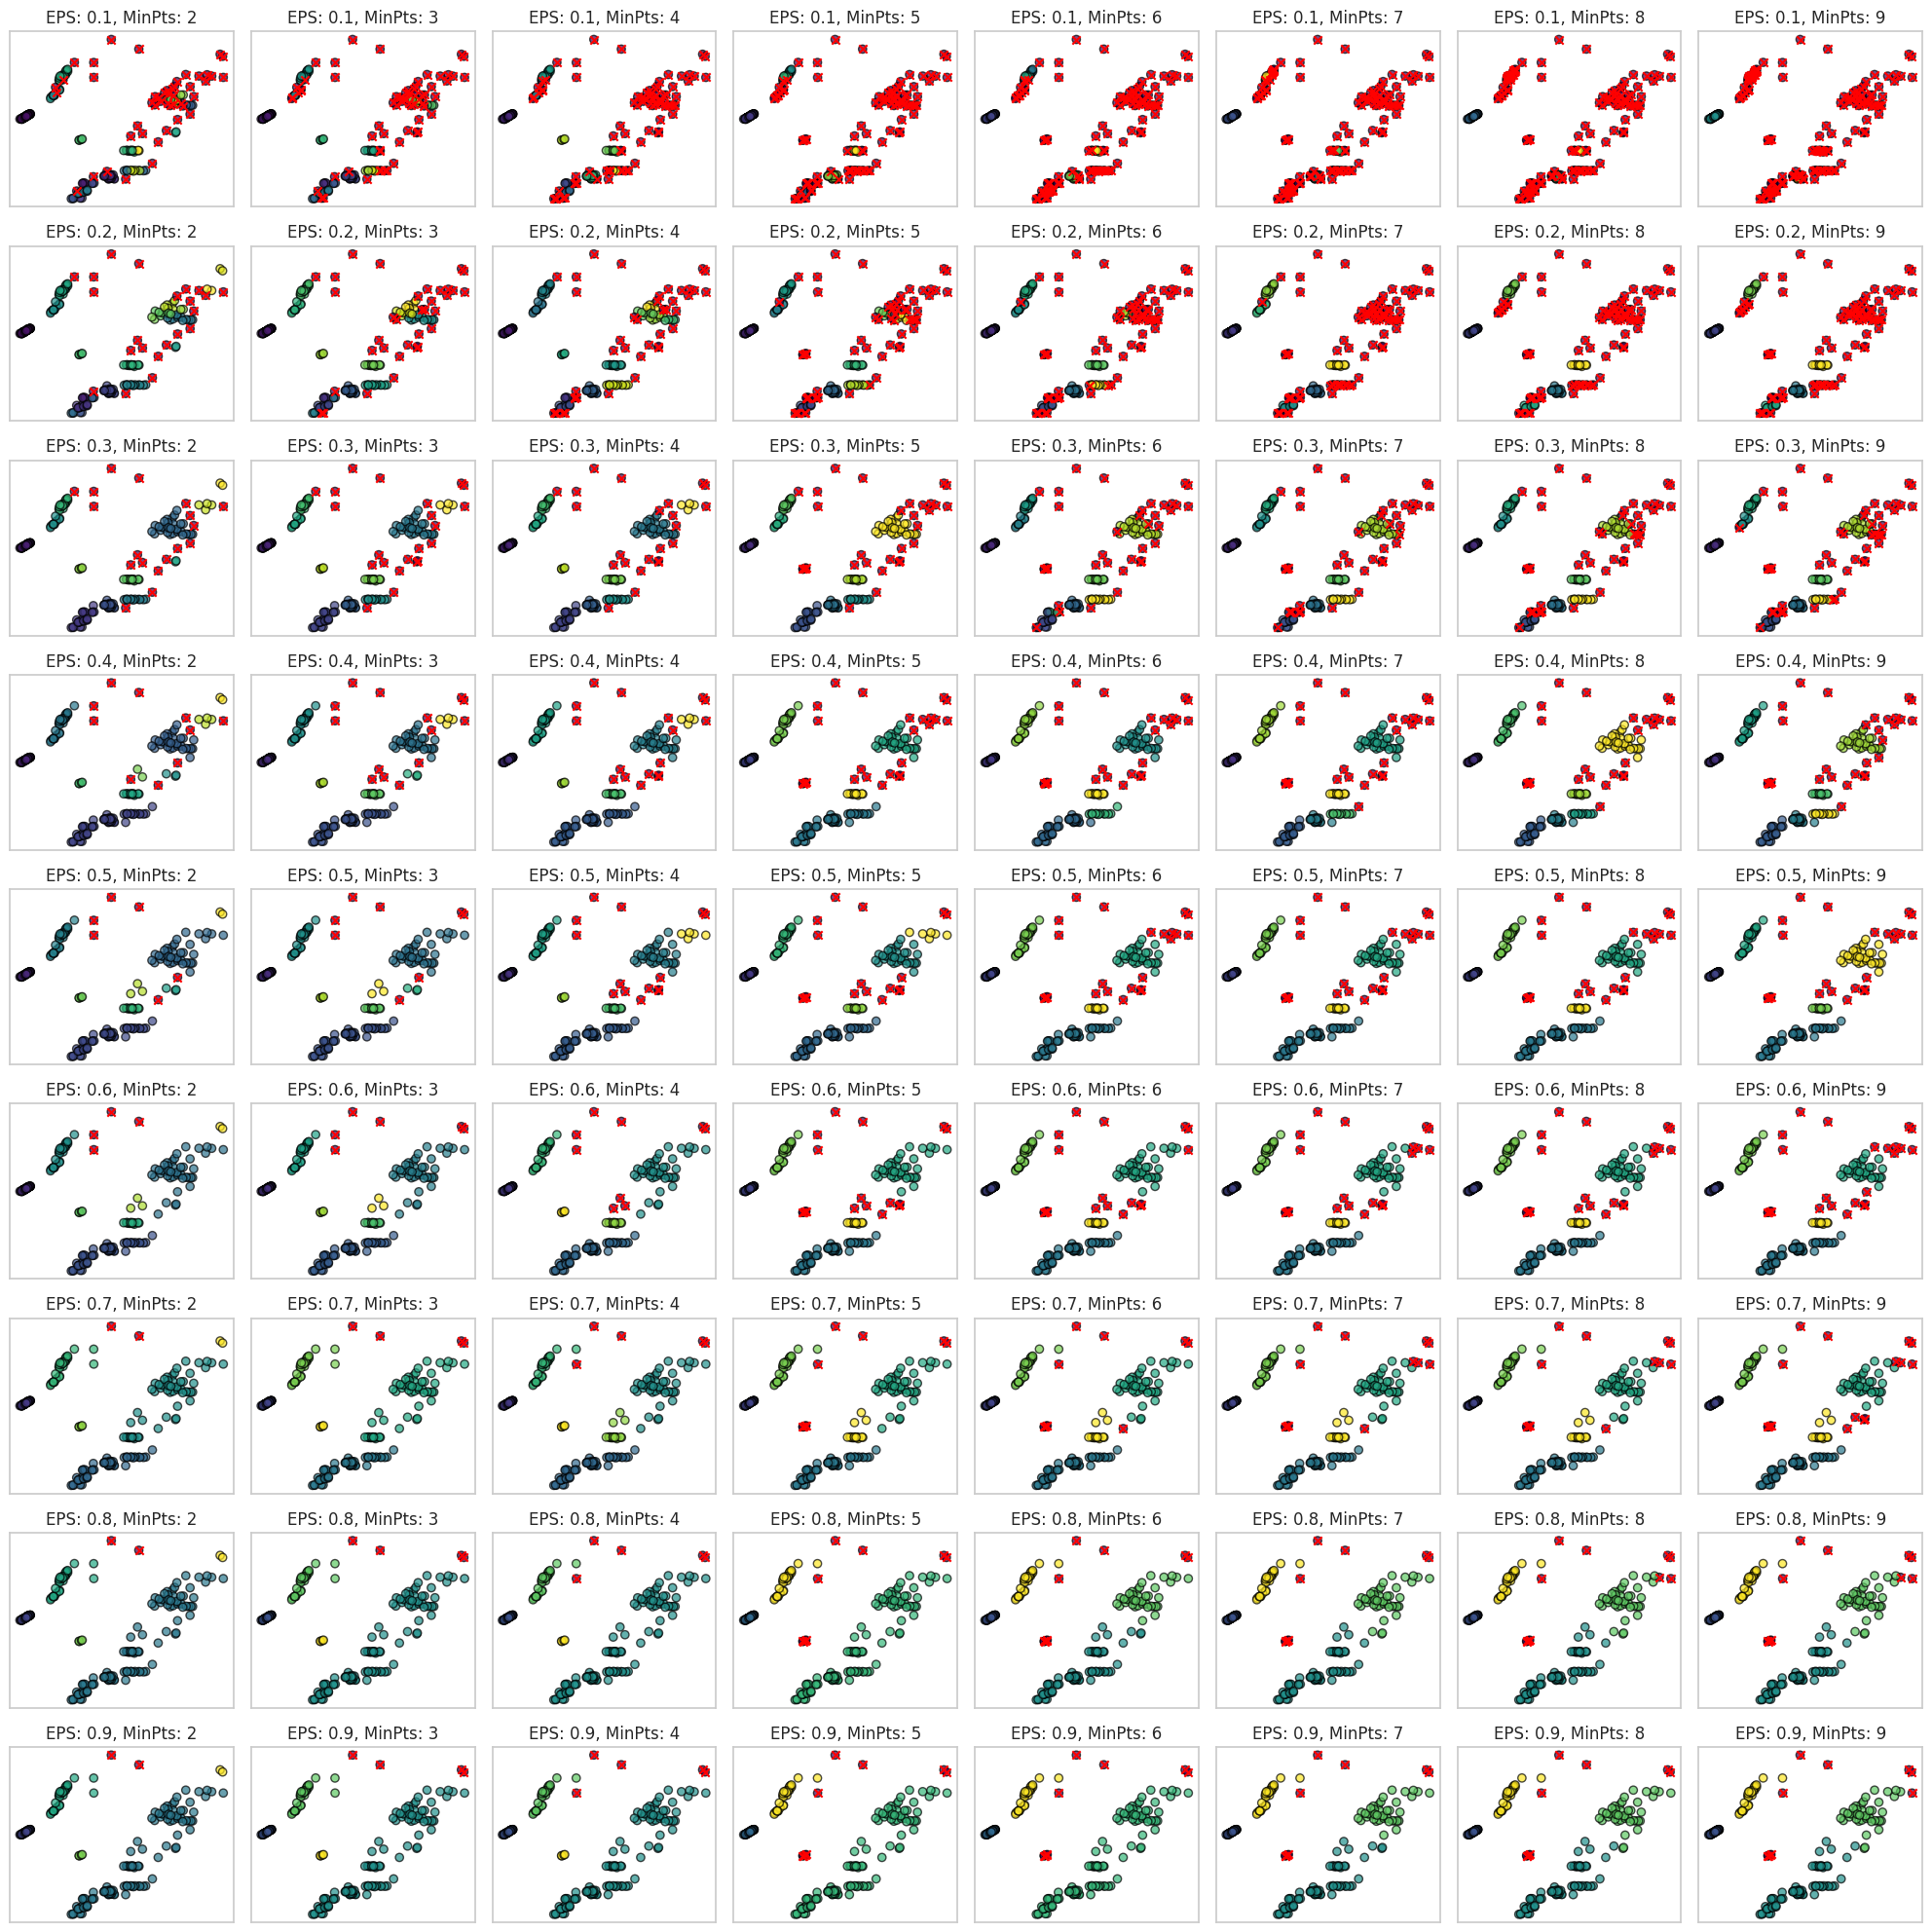

In [ ]:


eps_values = np.arange(0.1, 1.0, 0.1)  # Rango de valores para eps
min_samples_values = range(2, 10)  # Rango de valores para min_samples

fig, axs = plt.subplots(len(eps_values), len(min_samples_values), figsize=(20, 20), squeeze=False)

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        # Modelo DBSCAN
        modelo_dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        modelo_dbscan.fit(stars_pca_ohe)

        # Clasificación
        labels = modelo_dbscan.labels_

        # Número de clusters encontrados (sin contar ruido como un cluster)
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

        # Silhouette Score, sólo si hay más de un cluster y menos que el número total de puntos menos outliers
        if n_clusters_ > 1 and n_clusters_ < len(stars_pca_ohe) - np.sum(labels == -1):
            silhouette_score = metrics.silhouette_score(stars_pca_ohe, labels)
        else:
            silhouette_score = -1  # Indicativo de no aplicable o no válido

        # Plot
        axs[i, j].scatter(stars_pca_ohe[:, 0], stars_pca_ohe[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='black', alpha=0.7)
        axs[i, j].set_title(f'EPS: {eps:.1f}, MinPts: {min_samples}')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        # Marcar los outliers si existen
        if np.any(labels == -1):
            axs[i, j].scatter(stars_pca_ohe[labels == -1, 0], stars_pca_ohe[labels == -1, 1], color='red', marker='x')

plt.tight_layout()
plt.show()


Viendo esta comparativa, y mirando un poco donde hay un balance de outliers y clústers.

Estamos buscamos una configuración que no solo maximice el número de clusters identificados sino que también refleje una agrupación razonable y útil de los datos. Una buena configuración de **DBSCAN** debería minimizar el número de outliers, mientras mantiene una estructura de cluster coherente.



> Los clusters deberían ser densos y bien separados entre sí. Configuraciones donde los puntos en un cluster están muy dispersos pueden ser indicativos de un valor de eps demasiado alto o un MinPts demasiado bajos.


Con esto dicho y viendo las gráficas, las configuraciones con un eps entre **0.3 y 0.7,** y **un MinPts de aproximadamente 4 a 6** podrían ser un buen punto de partida.

#### BDSCAN: Buscando hiperparámetros con TSNE

Como antes, buscamos los mejores hiperparametros para el DBSCAN con TSNE.


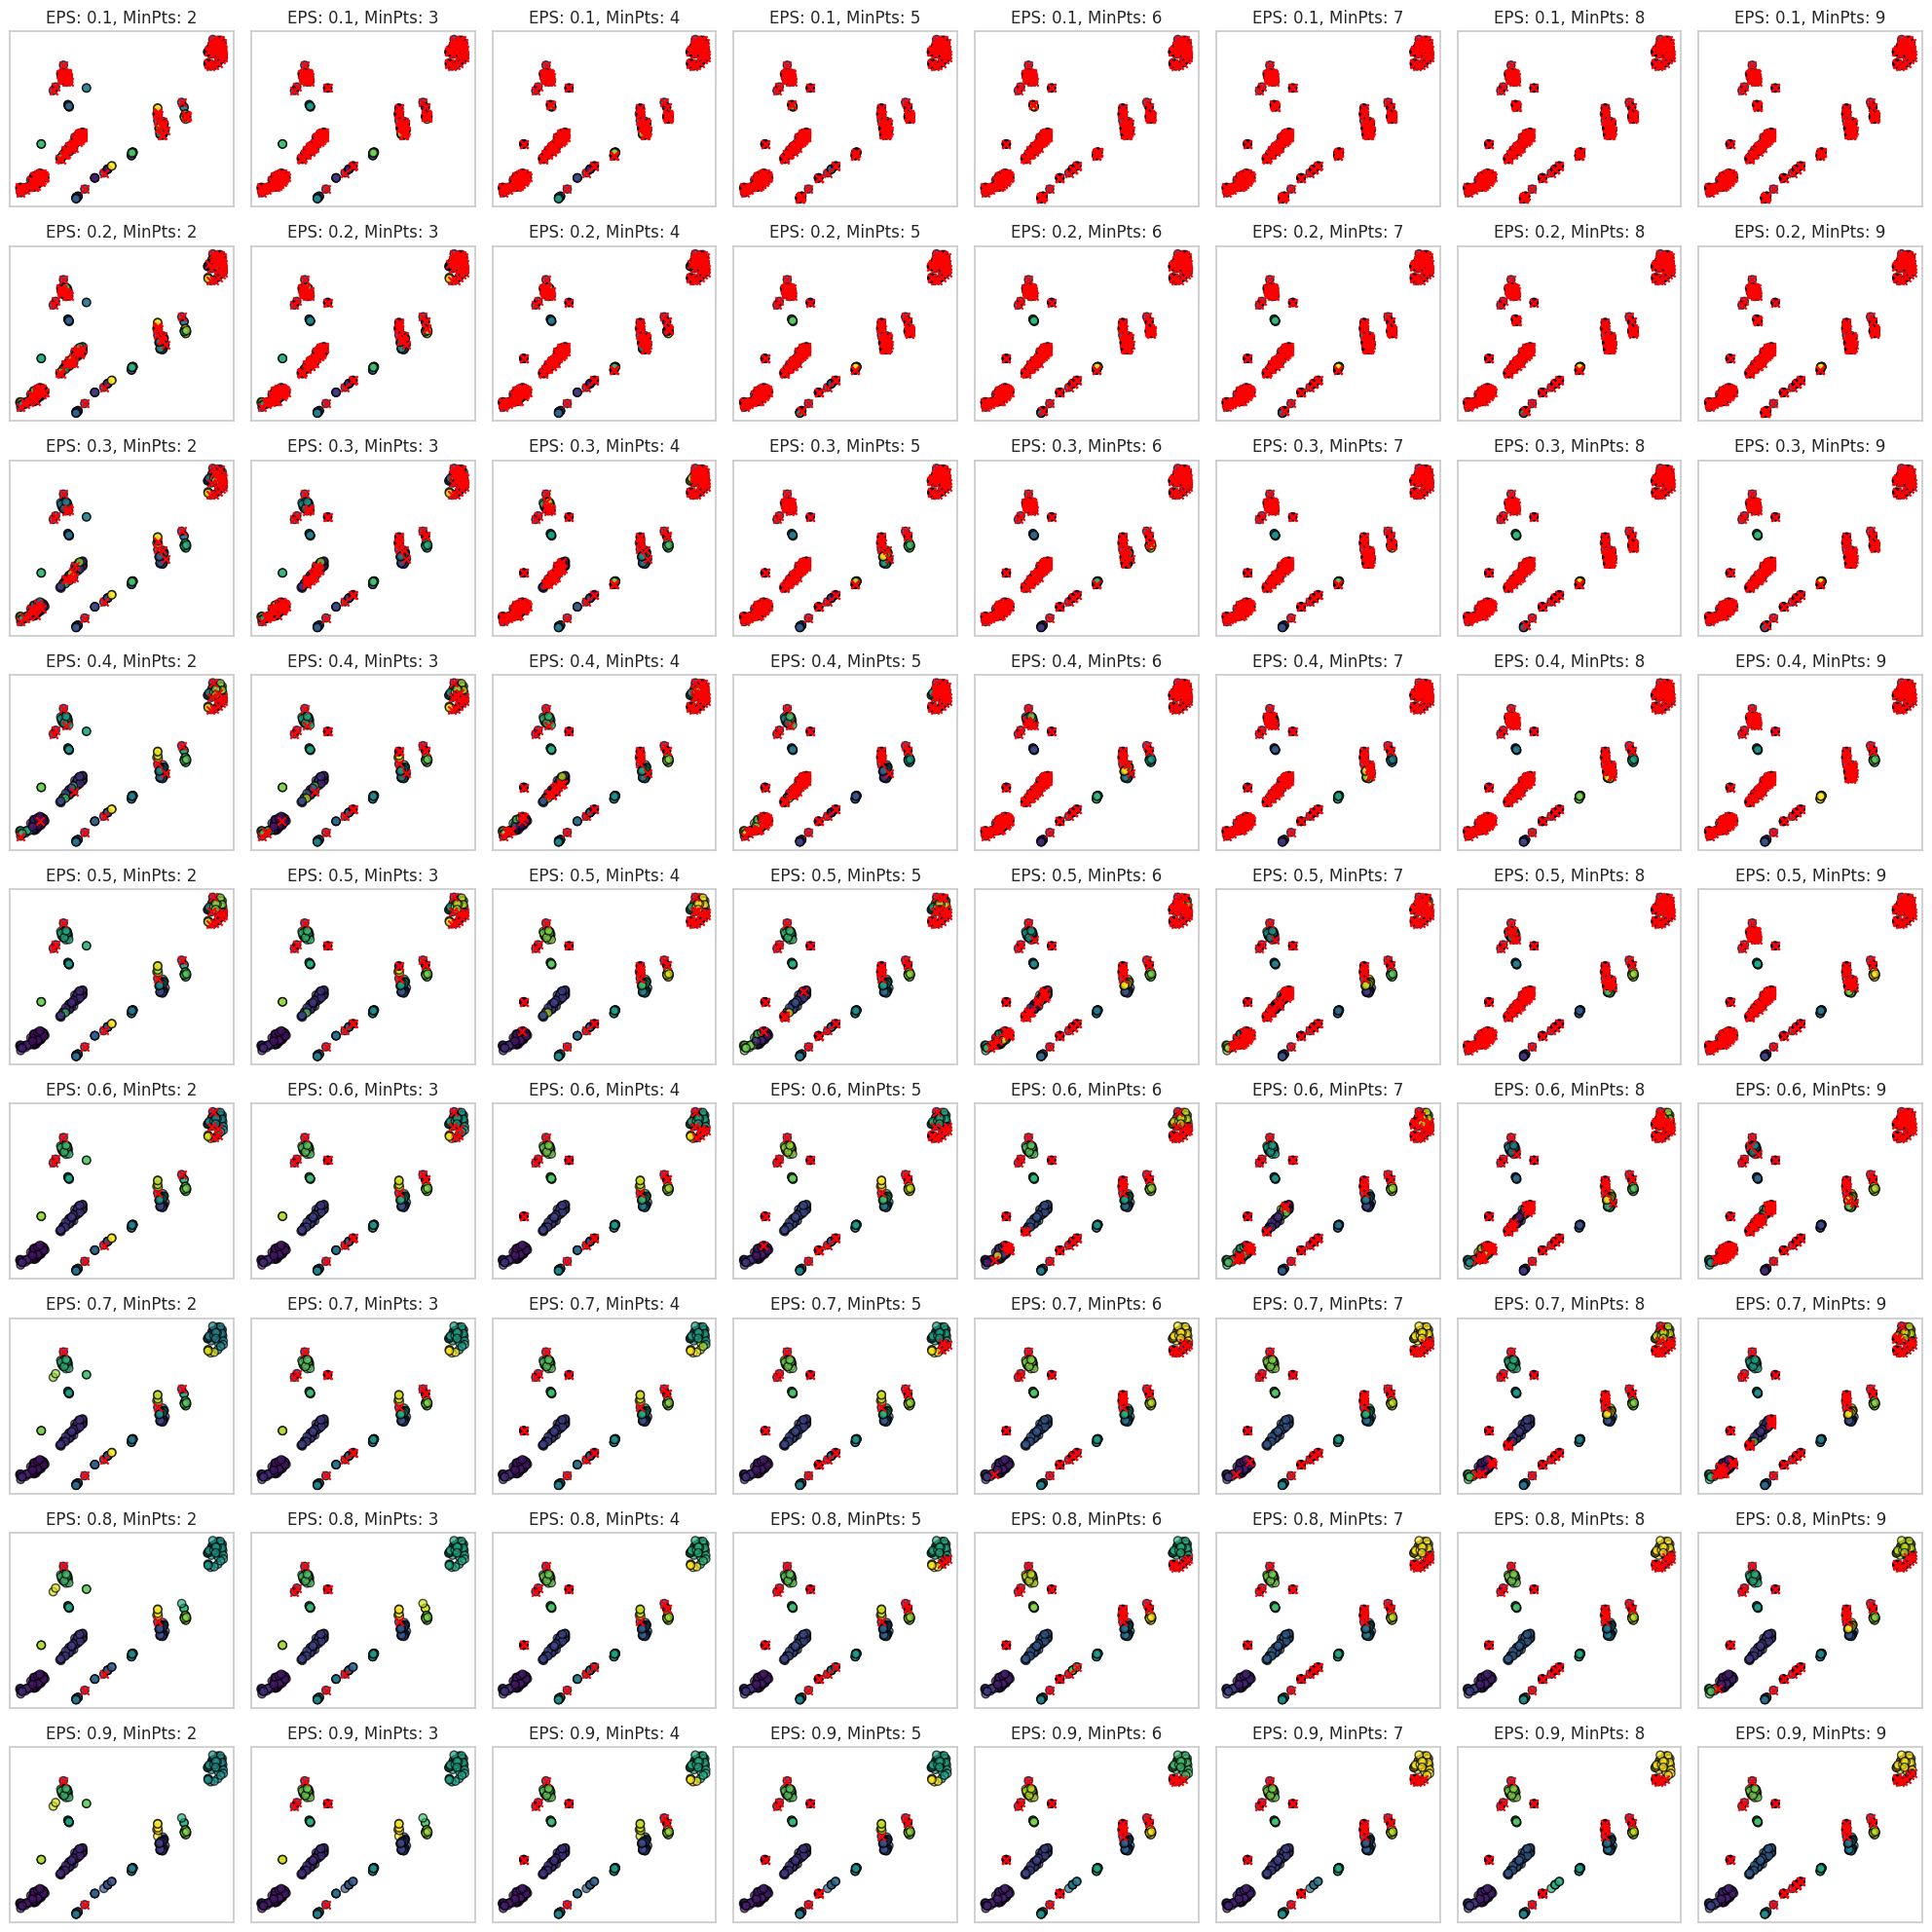

In [ ]:
eps_values = np.arange(0.1, 1.0, 0.1)  # Rango de valores para eps
min_samples_values = range(2, 10)  # Rango de valores para min_samples


fig, axs = plt.subplots(len(eps_values), len(min_samples_values), figsize=(20, 20), squeeze=False)

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        # Modelo DBSCAN
        modelo_dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        modelo_dbscan.fit(stars_tsne_ohe)

        # Clasificación
        labels = modelo_dbscan.labels_

        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

        # Silhouette Score, sólo si hay más de un cluster y menos que el número total de puntos menos outliers
        if n_clusters_ > 1 and n_clusters_ < len(stars_tsne_ohe) - np.sum(labels == -1):
            silhouette_score = metrics.silhouette_score(stars_tsne_ohe, labels)
        else:
            silhouette_score = -1  # Indicativo de no aplicable o no válido

        # Plot
        axs[i, j].scatter(stars_tsne_ohe[:, 0], stars_tsne_ohe[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='black', alpha=0.7)
        axs[i, j].set_title(f'EPS: {eps:.1f}, MinPts: {min_samples}')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        # Marcar los outliers si existen
        if np.any(labels == -1):
            axs[i, j].scatter(stars_tsne_ohe[labels == -1, 0], stars_tsne_ohe[labels == -1, 1], color='red', marker='x')

plt.tight_layout()
plt.show()


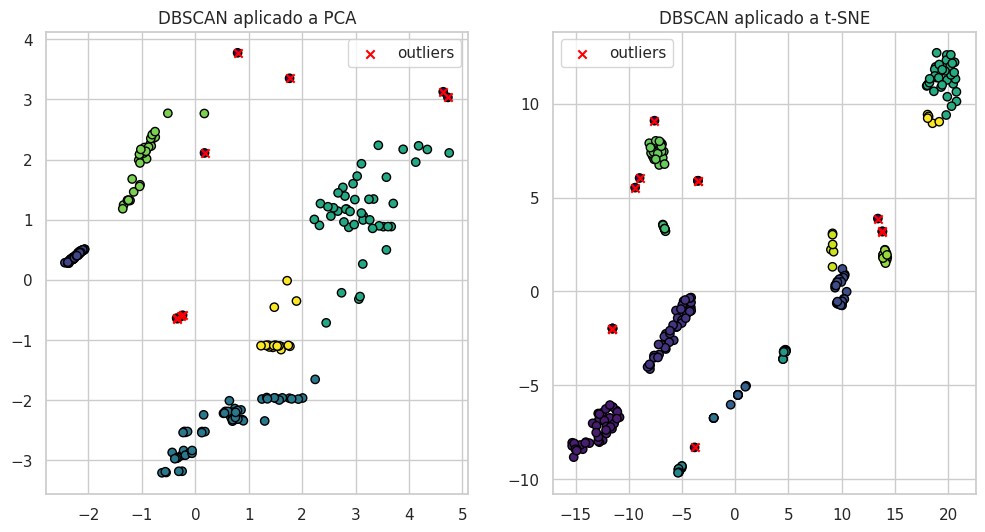

In [ ]:
# Ajustamos DBSCAN para PCA
modelo_dbscan_pca = DBSCAN(
    eps          = 0.7,
    min_samples  = 5,
    metric       = 'euclidean',
)
modelo_dbscan_pca.fit(X=stars_pca_ohe)
labels_pca = modelo_dbscan_pca.labels_

# Ajustamos DBSCAN para t-SNE
modelo_dbscan_tsne = DBSCAN(
    eps          = 0.9,
    min_samples  = 4,
    metric       = 'euclidean',
)
modelo_dbscan_tsne.fit(X=stars_tsne_ohe)
labels_tsne = modelo_dbscan_tsne.labels_

# Crear una figura con 1 fila y 2 columnas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Primer subplot para PCA
ax1.scatter(
    x = stars_pca_ohe[:, 0],
    y = stars_pca_ohe[:, 1],
    c = labels_pca,
    marker    = 'o',
    edgecolor = 'black',
    cmap='viridis'
)
ax1.scatter(
    x = stars_pca_ohe[labels_pca == -1, 0],
    y = stars_pca_ohe[labels_pca == -1, 1],
    c = 'red',
    marker    = 'x',
    edgecolor = 'black',
    label = 'outliers'
)
ax1.set_title('DBSCAN aplicado a PCA')
ax1.legend()

# Segundo subplot para t-SNE
ax2.scatter(
    x = stars_tsne_ohe[:, 0],
    y = stars_tsne_ohe[:, 1],
    c = labels_tsne,
    marker    = 'o',
    edgecolor = 'black',
    cmap='viridis'
)
ax2.scatter(
    x = stars_tsne_ohe[labels_tsne == -1, 0],
    y = stars_tsne_ohe[labels_tsne == -1, 1],
    c = 'red',
    marker    = 'x',
    edgecolor = 'black',
    label = 'outliers'
)
ax2.set_title('DBSCAN aplicado a t-SNE')
ax2.legend()

# Mostrar la figura
plt.show()

In [ ]:
# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters_pca = len(set(labels_pca)) - (1 if -1 in labels_pca else 0)
n_noise_pca    = list(labels_pca).count(-1)

n_clusters_tsne = len(set(labels_tsne)) - (1 if -1 in labels_tsne else 0)
n_noise_tsne    = list(labels_tsne).count(-1)

print("DBSCAN con PCA")
print(f'Número de clusters encontrados: {n_clusters_pca}')
print(f'Número de outliers encontrados: {n_noise_pca}')

print("DBSCAN con TSNE")
print(f'Número de clusters encontrados: {n_clusters_tsne}')
print(f'Número de outliers encontrados: {n_noise_tsne}')

DBSCAN con PCA
Número de clusters encontrados: 5
Número de outliers encontrados: 9
DBSCAN con TSNE
Número de clusters encontrados: 13
Número de outliers encontrados: 12


Se ha intentado entonces minimizar el número de outliers y manteniendo un número de clusters razonable. En este caso, parece ser que BDSCAN, aunque la nube de datos con TSNE sea más clara, funciona mejor con PCA.


## Ordinal Encoding

Primero, formateamos las columnas de nuestros datos de manera ordinal con las variables categóricas Color y Clase Espectral.

In [ ]:
colors = list(mapping.keys())
colors

['Red',
 'Orange-Red',
 'Orange',
 'Yellow-Orange',
 'Yellow',
 'White-Yellow',
 'White',
 'Blue-White',
 'Blue']

In [ ]:
spectral_classes = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

# Definir las categorías para el OrdinalEncoder
oe = OrdinalEncoder(categories=[spectral_classes, colors])

encoded_data = oe.fit_transform(stars_data[['Spectral_Class', 'Color']])

stars_data_encoded = stars_data.drop(['Spectral_Class', 'Color'], axis=1)
stars_data_encoded['Spectral_Class_encoded'] = encoded_data[:, 0]
stars_data_encoded['Color_encoded'] = encoded_data[:, 1]
stars_data_encoded

Temperature              L          R    A_M  Spectral_Class_encoded  \
0           3068       0.002400     0.1700  16.12                     6.0   
1           3042       0.000500     0.1542  16.60                     6.0   
2           2600       0.000300     0.1020  18.70                     6.0   
3           2800       0.000200     0.1600  16.65                     6.0   
4           1939       0.000138     0.1030  20.06                     6.0   
..           ...            ...        ...    ...                     ...   
235        38940  374830.000000  1356.0000  -9.93                     0.0   
236        30839  834042.000000  1194.0000 -10.63                     0.0   
237         8829  537493.000000  1423.0000 -10.73                     2.0   
238         9235  404940.000000  1112.0000 -11.23                     2.0   
239        37882  294903.000000  1783.0000  -7.80                     0.0   

     Color_encoded  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
..             ...  
235            8.0  
236            8.0  
237            6.0  
238            6.0  
239            8.0  

[240 rows x 6 columns]

In [ ]:
print("Categorías utilizadas para la codificación:", oe.categories_)

Categorías utilizadas para la codificación: [array(['O', 'B', 'A', 'F', 'G', 'K', 'M'], dtype=object), array(['Red', 'Orange-Red', 'Orange', 'Yellow-Orange', 'Yellow',
       'White-Yellow', 'White', 'Blue-White', 'Blue'], dtype=object)]


 ### Escalado y PCA

In [ ]:
# Escalado primero
datos_escalados_oe = scale(stars_data_encoded)

# PCA
pca = PCA(n_components=2)
stars_pca_oe = pca.fit_transform(datos_escalados_oe)
pd.DataFrame(stars_pca_oe)

0         1
0   -2.076410 -0.141135
1   -2.095980 -0.158994
2   -2.197765 -0.229721
3   -2.109804 -0.155463
4   -2.282131 -0.267054
..        ...       ...
235  4.093712  1.035398
236  4.611041  2.087133
237  2.352912  2.641254
238  2.016937  1.968293
239  3.937358  1.321008

[240 rows x 2 columns]

### Kmeans

#### Kmeans: Método Elbow

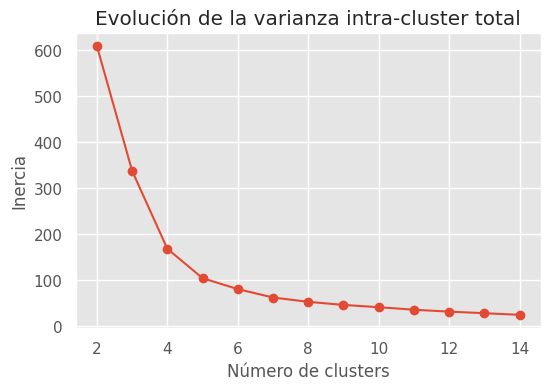

In [ ]:
# Método Elbow para identificar el número óptimo de clusters
range_n_clusters = range(2, 15)
inertias = []

for n_clusters in range_n_clusters:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('kmeans', KMeans(n_clusters=n_clusters, n_init=20, random_state=100434072))
    ])
    # Ajustar el pipeline a los datos
    pipeline.fit(stars_data_encoded)
    # Obtener la inercia del paso kmeans
    inertias.append(pipeline.named_steps['kmeans'].inertia_)

# Graficar los resultados del método Elbow
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número de clusters')
ax.set_ylabel('Inercia')
plt.show()


#### Kmeans: Método Silhouette




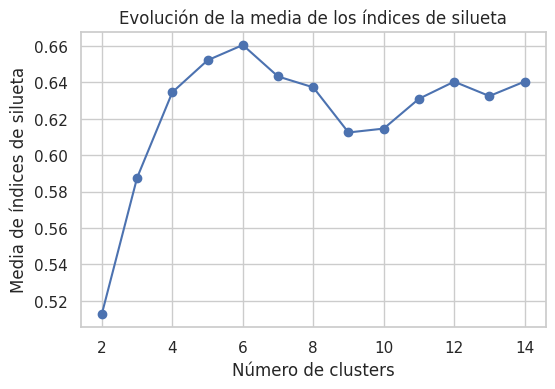

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Método silhouette para identificar el número óptimo de clusters
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

# Preparar el pipeline sin incluir KMeans
preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])

# Transformar los datos usando el pipeline de preprocesamiento
data_transformed = preprocessing_pipeline.fit_transform(stars_data_encoded)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=100434072)
    cluster_labels = kmeans.fit_predict(data_transformed)
    silhouette_avg = silhouette_score(data_transformed, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

# Graficar los resultados de silueta
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de la media de los índices de silueta")
ax.set_xlabel('Número de clusters')
ax.set_ylabel('Media de índices de silueta')
plt.show()


Podemos ver, que según los métodos Elbow y Silhouette, el número de clústers es 6. Además, podemos ver que el score es de 0.66, muchísimo mejor que el obtenido en One Hot Encoding, que era de 0.20 - 0.35 como mucho.

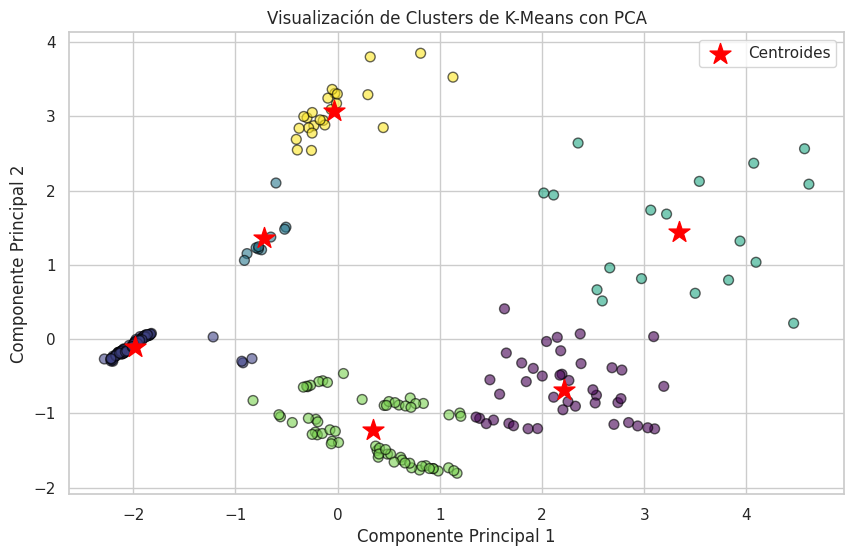

In [ ]:
# Número óptimo de clusters
optimal_clusters = 6

# Ajustar K-Means
kmeans = KMeans(n_clusters=optimal_clusters, n_init=20, random_state=100434072)
cluster_labels = kmeans.fit_predict(stars_pca_oe)

import matplotlib.pyplot as plt

# Graficar los clusters
plt.figure(figsize=(10, 6))
plt.scatter(stars_pca_oe[:, 0], stars_pca_oe[:, 1], c=cluster_labels, cmap='viridis', marker='o', edgecolor='black', s=50, alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=250, c='red', marker='*', label='Centroides')
plt.title('Visualización de Clusters de K-Means con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()


Podemos observar como se forman los 6 clústers con Kmeans.

### Cluster Jerárquico

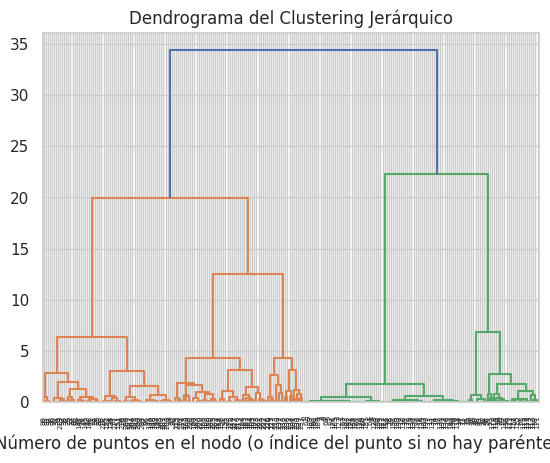

In [ ]:
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, compute_distances=True)
model = clustering.fit(stars_pca_oe)

def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''
    # Create linkage matrix and then plot the dendrogram
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Llamamos a la función para graficar el dendrograma
plt.title('Dendrograma del Clustering Jerárquico')
plot_dendrogram(model)
plt.xlabel("Número de puntos en el nodo (o índice del punto si no hay paréntesis).")
plt.show()


In [ ]:
# Ajustar modelos de clustering jerárquico con diferentes tipos de linkage
modelo_hclust_complete = AgglomerativeClustering(
    metric='euclidean',
    linkage='complete',
    distance_threshold=0,
    n_clusters=None
)
modelo_hclust_complete.fit(X=stars_pca_oe)

modelo_hclust_average = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'average',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_average.fit(X=stars_pca_oe)

modelo_hclust_ward = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'ward',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_ward.fit(X=stars_pca_oe)

AgglomerativeClustering(distance_threshold=0, metric='euclidean',
                        n_clusters=None)

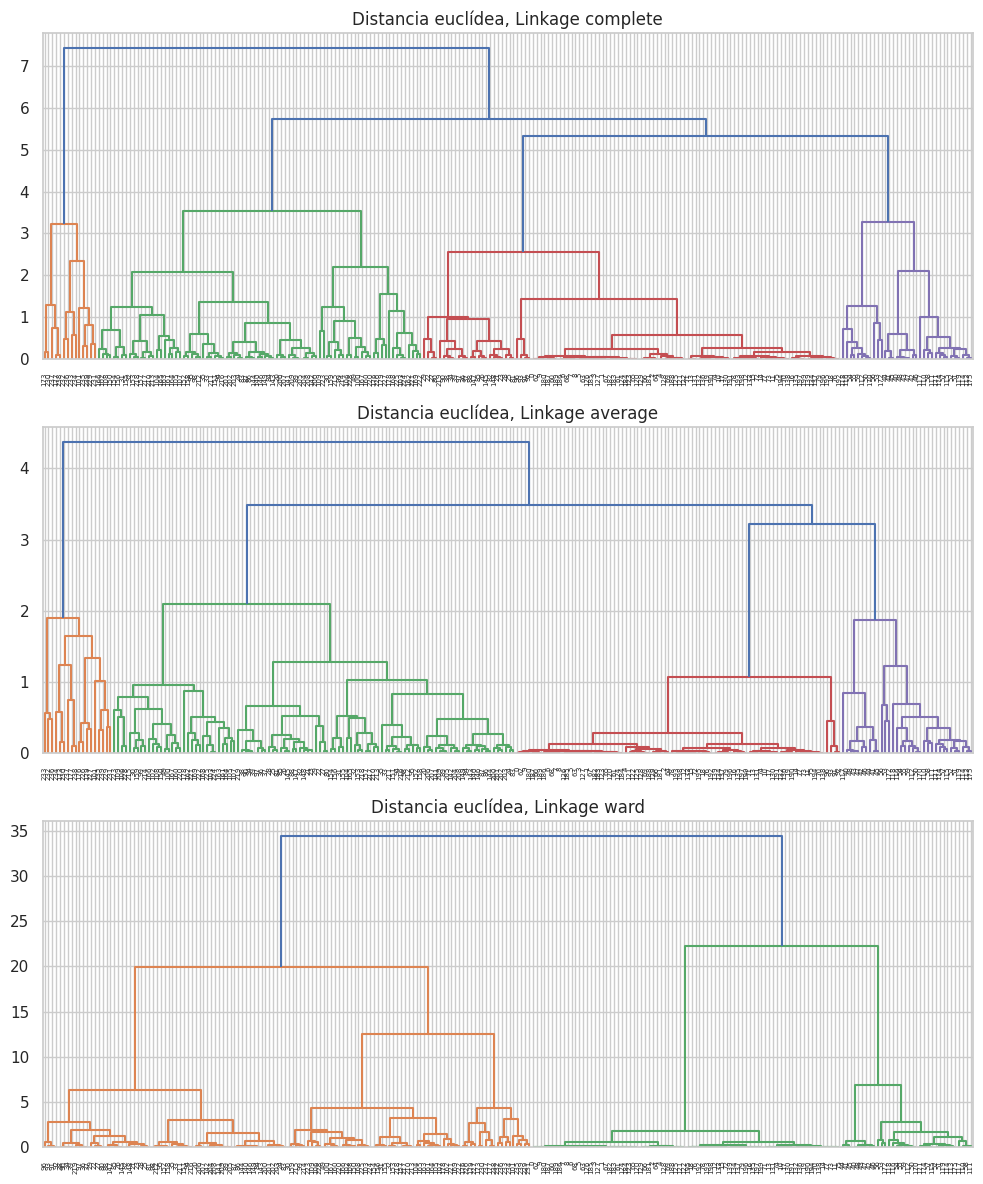

In [ ]:
# Dendrogramas
# ==============================================================================

fig, axs = plt.subplots(3, 1, figsize=(10, 12))
plot_dendrogram(modelo_hclust_complete, labels=range(len(stars_pca_oe)), ax=axs[0])
axs[0].set_title("Distancia euclídea, Linkage complete")
plot_dendrogram(modelo_hclust_average, labels=range(len(stars_pca_oe)), ax=axs[1])
axs[1].set_title("Distancia euclídea, Linkage average")
plot_dendrogram(modelo_hclust_ward,  labels=range(len(stars_pca_oe)),ax=axs[2])
axs[2].set_title("Distancia euclídea, Linkage ward")
plt.tight_layout()
plt.show()

Igual que antes, el Linkage Ward demuestrala mejor organización de Clústers. Así que procedo a usarlo para poner la linea de corte.

Podemos ver que a la altura de 10 sería un corte razonable.

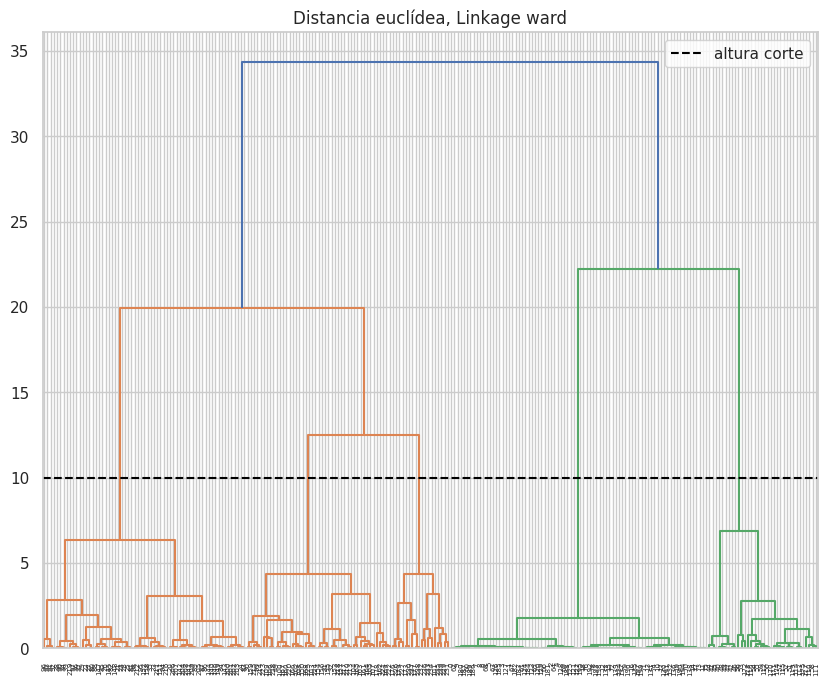

In [ ]:
# Ward
fig, ax = plt.subplots(1, 1, figsize=(10,8))
altura_corte_linkage_ward = 10
plot_dendrogram(modelo_hclust_ward,ax=ax,labels=range(len(stars_pca_oe)))
ax.set_title("Distancia euclídea, Linkage ward")
ax.axhline(y=altura_corte_linkage_ward, c = 'black', linestyle='--', label='altura corte')
ax.legend();

#### Jerárquico: Método Silhouette

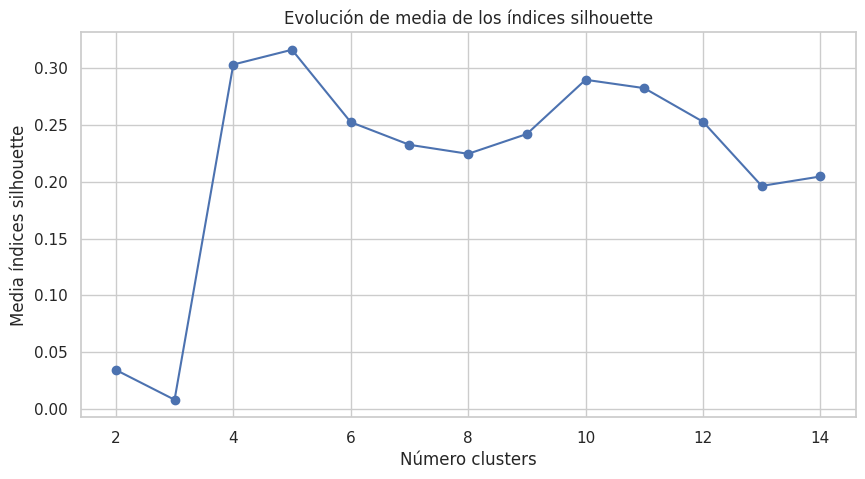

In [ ]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('jerarquico', AgglomerativeClustering(
        affinity   = 'euclidean',
        linkage    = 'ward',
        n_clusters = n_clusters,
    ))
    ])

    cluster_labels = pipeline.fit_predict(stars_data_encoded)
    silhouette_avg = silhouette_score(stars_data_ohe, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

Y como podemos ver, el punto máximo es el 5, con un score de aproximadamente 0.32. Es un score muy bajo aún, pero podemos comprobar que da los mismos 5 clústers que viendo los dendogramas.

### DBSCAN
Finalmente, hacemos el DBSCAN para el Ordinal Encoding. Vemos la nube de datos inicial y luego comparamos diferentes hiperparametros para el modelo.

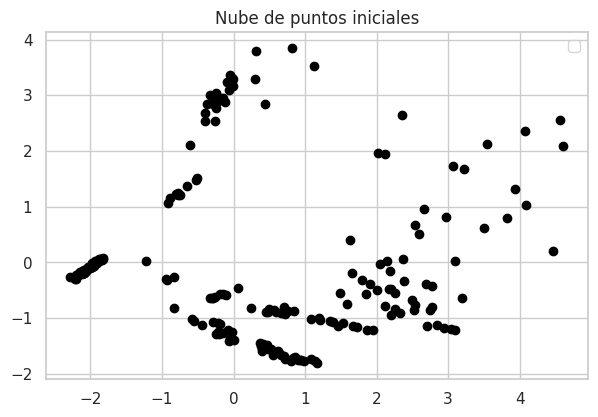

In [ ]:
# Visualizado de datos
# ==============================================================================

fig, ax = plt.subplots(1, 1, figsize=(7, 4.5))

ax.scatter(
    x = stars_pca_oe[:, 0],
    y = stars_pca_oe[:, 1],
    c = 'black',
    marker    = 'o',
    edgecolor = 'black'
)
ax.legend()
ax.set_title('Nube de puntos iniciales');

Ahora graficamos con diferentes hiperparametros para ver cuáles son mejores.

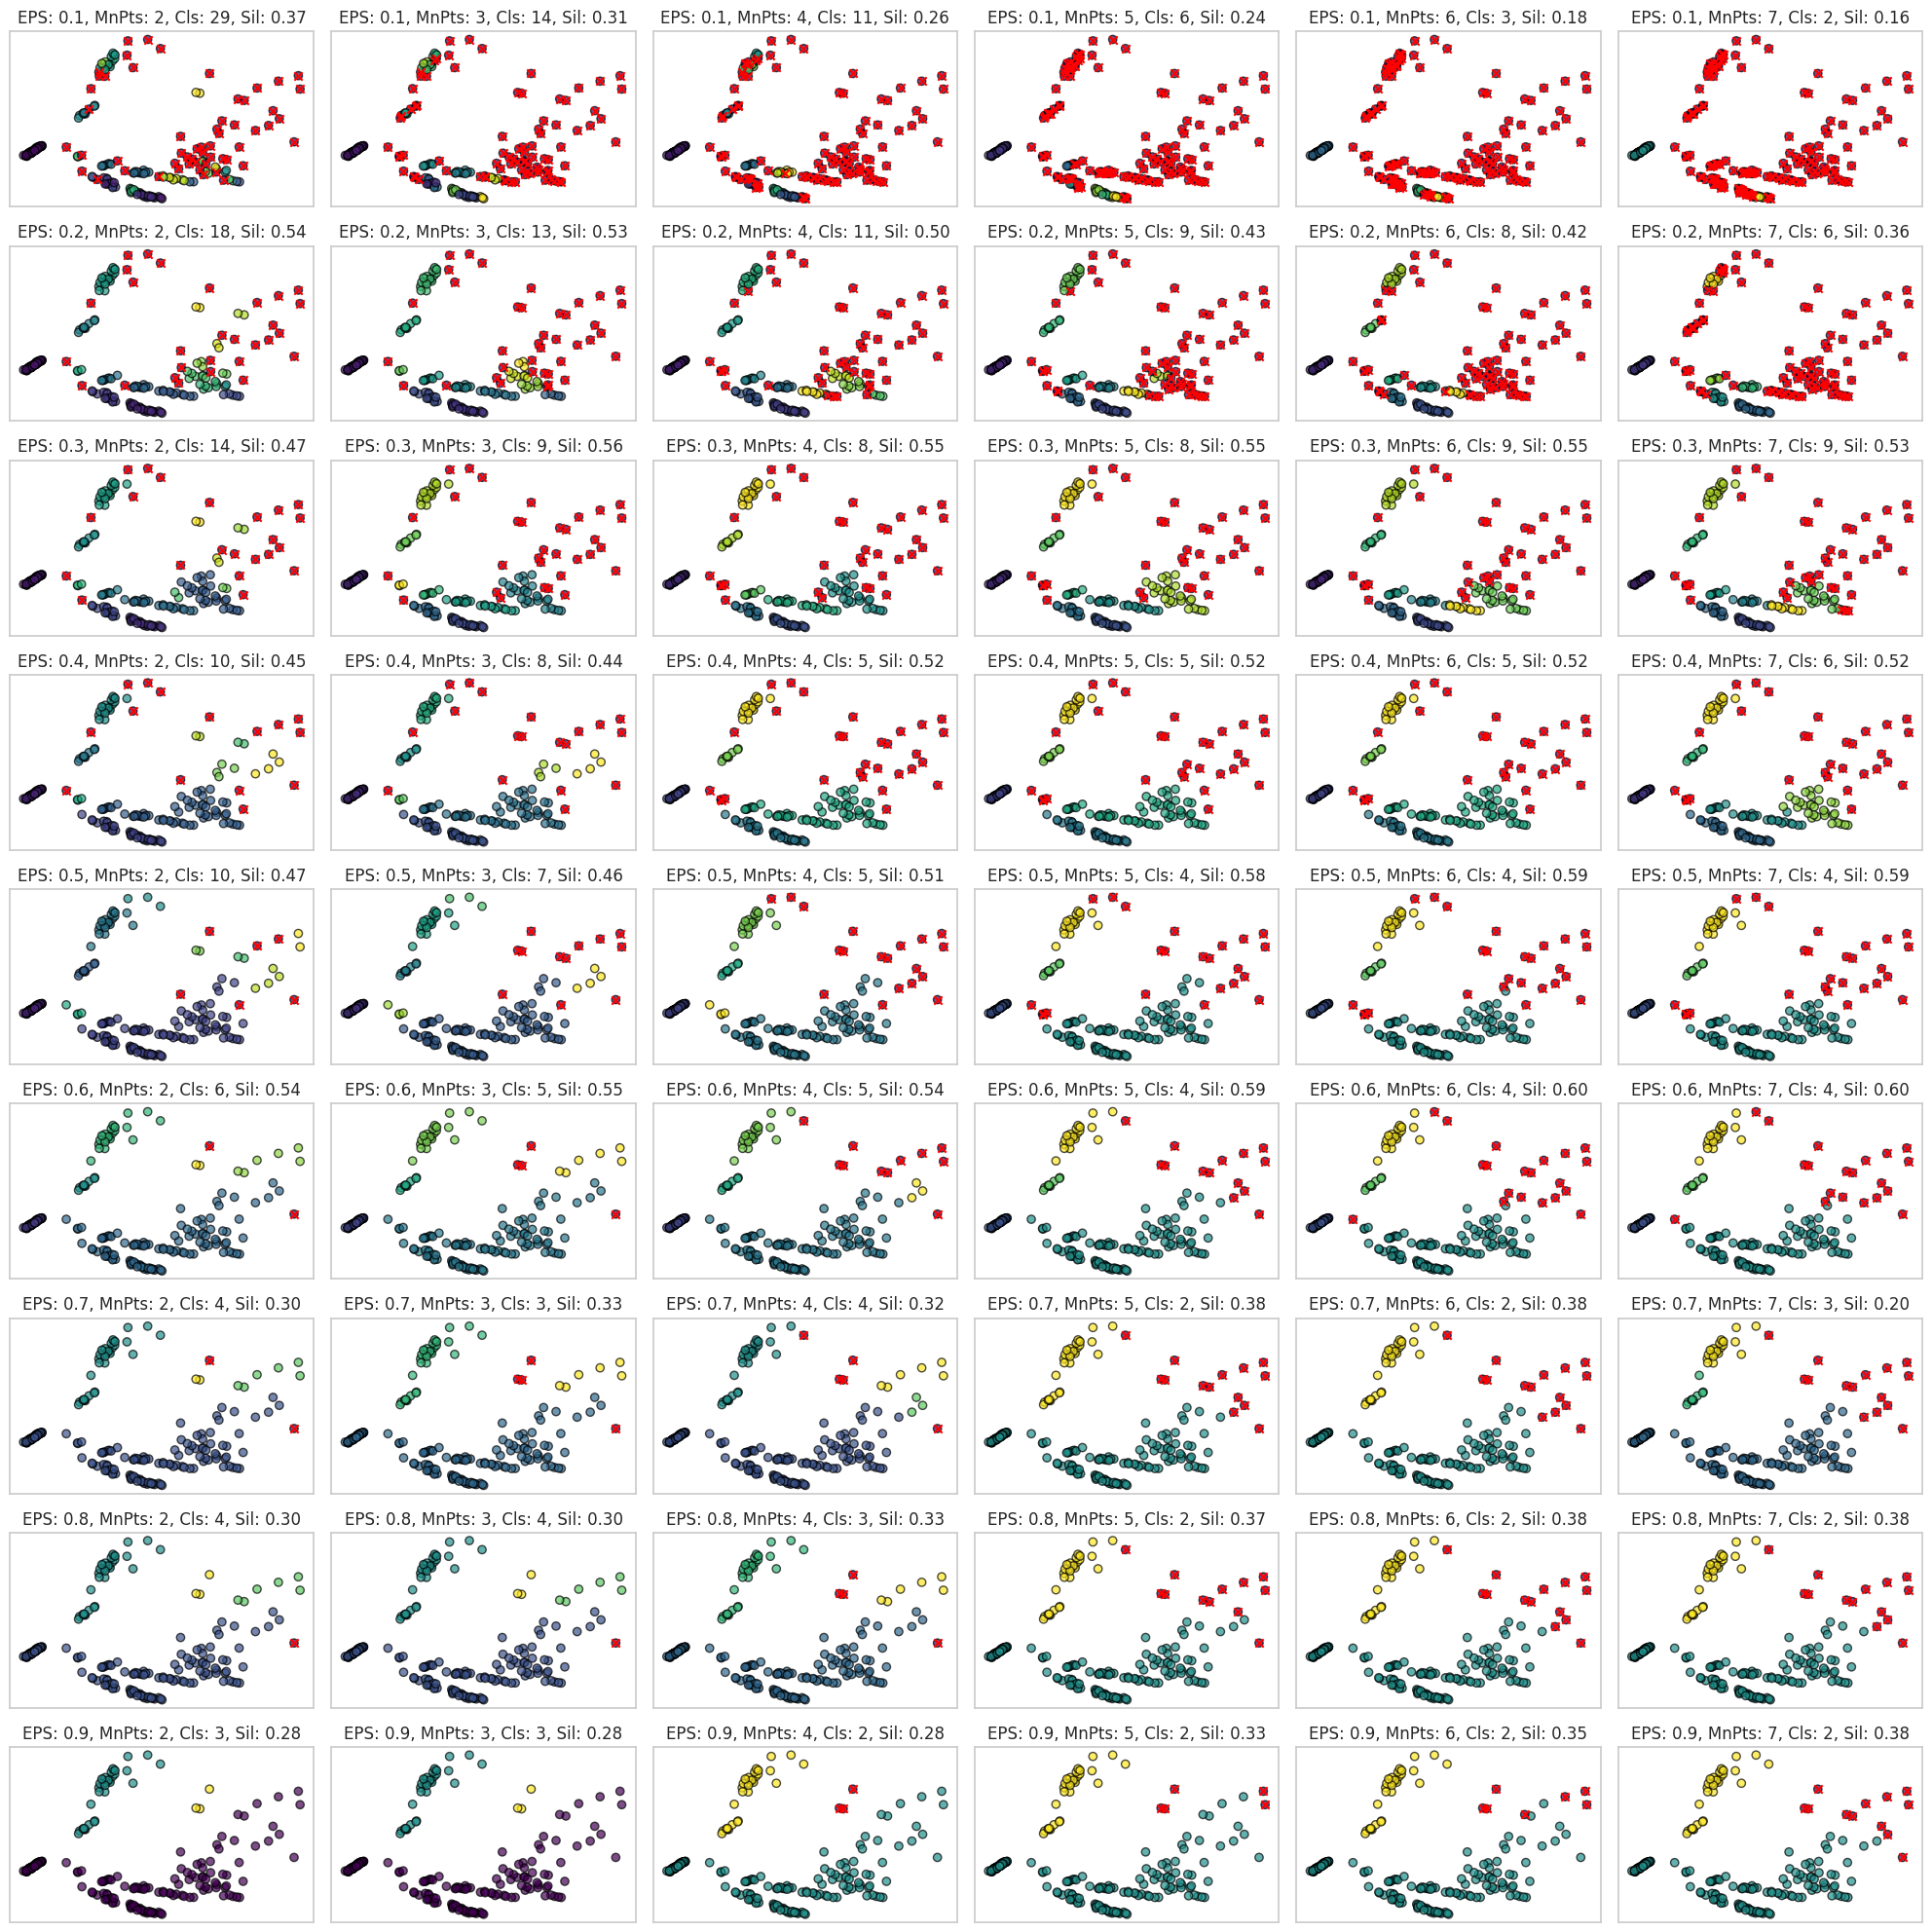

In [ ]:

eps_values = np.arange(0.1, 1.0, 0.1)  # Rango de valores para eps
min_samples_values = range(2, 8)  # Rango de valores para min_samples

fig, axs = plt.subplots(len(eps_values), len(min_samples_values), figsize=(20, 20), squeeze=False)

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        # Modelo DBSCAN
        modelo_dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        modelo_dbscan.fit(stars_pca_oe)

        # Clasificación
        labels = modelo_dbscan.labels_

        # Número de clusters encontrados (sin contar ruido como un cluster)
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

        # Silhouette Score, sólo si hay más de un cluster y menos que el número total de puntos menos outliers
        if n_clusters_ > 1 and n_clusters_ < len(labels) - np.sum(labels == -1):
            silhouette_score = metrics.silhouette_score(stars_pca_oe, labels)
        else:
            silhouette_score = -1  # Indicativo de no aplicable o no válido

        # Plot
        axs[i, j].scatter(stars_pca_oe[:, 0], stars_pca_oe[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='black', alpha=0.7)
        axs[i, j].set_title(f'EPS: {eps:.1f}, MnPts: {min_samples}, Cls: {n_clusters_}, Sil: {silhouette_score:.2f}')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        # Marcar los outliers si existen
        if np.any(labels == -1):
            axs[i, j].scatter(stars_pca_oe[labels == -1, 0], stars_pca_oe[labels == -1, 1], color='red', marker='x')

plt.tight_layout()
plt.show()


In [ ]:
# Modelo
# ==============================================================================
modelo_dbscan = DBSCAN(
    eps          = 0.6,
    min_samples  = 3,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X=stars_pca_oe)

DBSCAN(eps=0.6, min_samples=3)

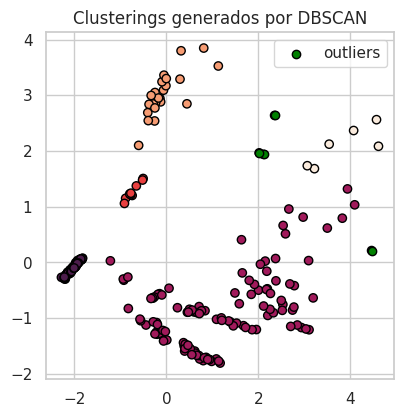

In [ ]:
# Clasificación
# ==============================================================================
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = stars_pca_oe[:, 0],
    y = stars_pca_oe[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = stars_pca_oe[labels == -1, 0],
    y = stars_pca_oe[labels == -1, 1],
    c = 'green',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN');

In [ ]:
# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters_pca = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_pca    = list(labels).count(-1)

print("DBSCAN con PCA")
print(f'Número de clusters encontrados: {n_clusters_pca}')
print(f'Número de outliers encontrados: {n_noise_pca}')

DBSCAN con PCA
Número de clusters encontrados: 5
Número de outliers encontrados: 4


Con esta configuración, tenemos un número balanceado de clústers y outliers.



## Conclusiones

**A partir de los resultados obtenidos, ¿qué pipeline de clustering, es decir, qué
transformaciones de datos, algoritmo, con sus hiperparámetros, transformación
de datos y análisis de resultados recomendaría realizar?**

Luego de haber analizado todos los datos, tanto con One Hot Encoding y Ordinal Encoding, y los diferentes modelos. Puedo concluir, que dado las gráficas resultantes y los scores de silueta, en este caso en particular, el modelo que mejor se comporta es el KMeans con codificación Ordinal ya que da el índice de silueta más alto, de 0.66, y por lo tanto, son los clústers de mejor calidad.

Que seria este:

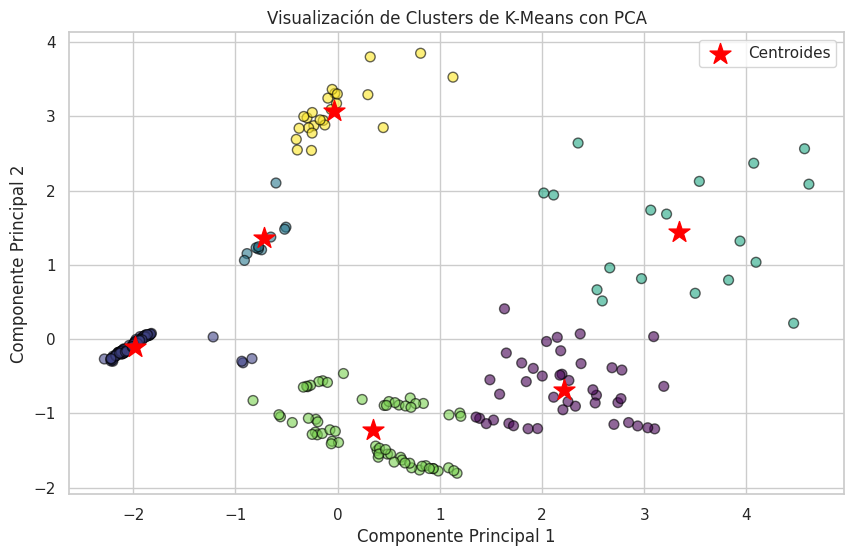

In [ ]:
# Número óptimo de clusters
optimal_clusters = 6

# Ajustar K-Means
kmeans = KMeans(n_clusters=optimal_clusters, n_init=20, random_state=100434072)
cluster_labels = kmeans.fit_predict(stars_pca_oe)

import matplotlib.pyplot as plt

# Graficar los clusters
plt.figure(figsize=(10, 6))
plt.scatter(stars_pca_oe[:, 0], stars_pca_oe[:, 1], c=cluster_labels, cmap='viridis', marker='o', edgecolor='black', s=50, alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=250, c='red', marker='*', label='Centroides')
plt.title('Visualización de Clusters de K-Means con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()


Luego, nos proporcionan una tabla con las estrellas que la astronomía utiliza
habitualmente:

Clase: Enana roja
Temperatura: 3.000
...
Color: rojo
Clase Espectral: K-M

Clase: Enana marrón
Temperatura: 3.300
...
Color: rojo
Clase Espectral: M

Clase: Enana blanca
Temperatura: 14.000
...
Color: blanca
Clase Espectral: B-G

Clase: Estrella en secuencia
principal
Temperatura: 16.000
...
Color: blanca-
amarilla
Clase Espectral: B-M

Clase: Super gigante
Temperatura: 15.000
...
Color: blanca-
amarilla
Clase Espectral: B-M


Clase: Hiper gigante
Temperatura: 11.000
...
Color: amarilla
Clase Espectral: B-M


Podemos ver las caracteristicas de cada cluster generado. Primero, vemos las categóricas, tanto color como clase espectral.

              Spectral_Class       Color
cluster_label                           
0                          O        Blue
1                          M         Red
2                          M         Red
3                          O        Blue
4                          B  Blue-White
5                          M         Red


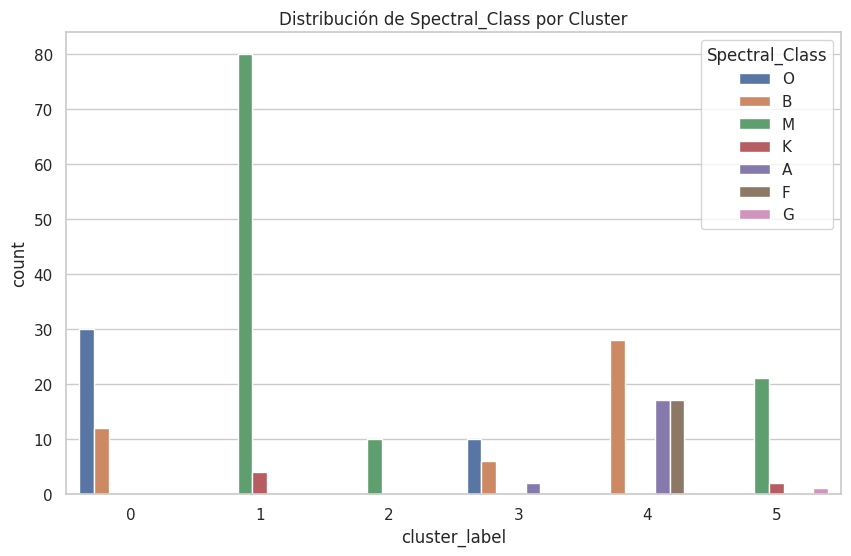

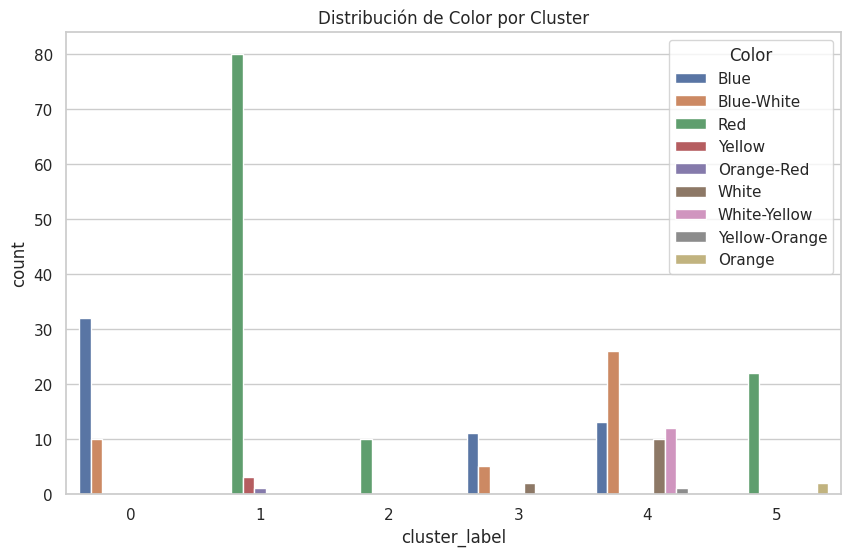

In [ ]:
# Crear un DataFrame solo con las columnas codificadas para revertirlas
encoded_features = stars_data_encoded[['Spectral_Class_encoded', 'Color_encoded']]

# Revertir las codificaciones a las categorías originales
decoded_categories = oe.inverse_transform(encoded_features)
decoded_df = pd.DataFrame(decoded_categories, columns=['Spectral_Class', 'Color'])

# Agregar estas columnas decodificadas al DataFrame original
stars_data_encoded['Spectral_Class'] = decoded_df['Spectral_Class']
stars_data_encoded['Color'] = decoded_df['Color']
stars_data_encoded['cluster_label'] = kmeans.labels_

# Agrupar por etiqueta de cluster y obtener la moda para las características categóricas
cluster_characteristics_categorical = stars_data_encoded.groupby('cluster_label').agg({
    'Spectral_Class': lambda x: x.mode()[0],  # Moda de la clase espectral
    'Color': lambda x: x.mode()[0]  # Moda del color
})

print(cluster_characteristics_categorical)

# Visualizar la distribución de clases espectrales y colores en cada cluster
for category in ['Spectral_Class', 'Color']:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='cluster_label', hue=category, data=stars_data_encoded)
    plt.title(f'Distribución de {category} por Cluster')
    plt.legend(title=category)
    plt.show()


Y ahora vemos las variables numéricas, en este caso, Temperatura, Longitud y magnitud

              Temperature                                L            \
                     mean   median   min    max       mean    median   
cluster_label                                                          
0                21793.36  22675.0  5752  39000  203221.86  203450.0   
1                 3213.88   3186.0  1939   5112       0.02       0.0   
2                 3466.80   3574.5  3008   3826  206600.00  197500.0   
3                24015.89  24317.5  8829  40000  512365.61  471216.5   
4                12522.15  12054.0  5300  25000     133.97       0.0   
5                 3782.38   3612.0  3399   6850  245541.67  219000.0   

                                          R                              A_M  \
                    min        max     mean   median     min      max   mean   
cluster_label                                                                  
0                4720.0  537430.00    52.88    35.00    5.49   708.90  -5.55   
1                   0.0       0

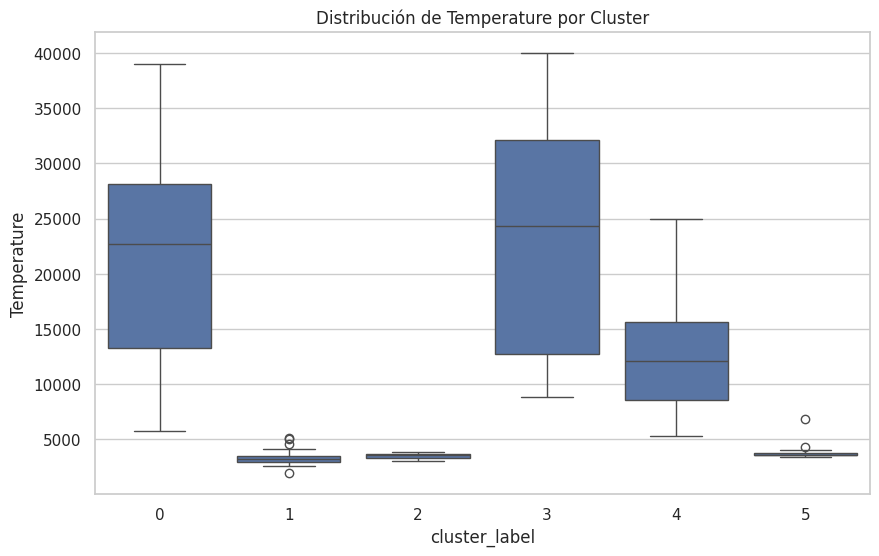

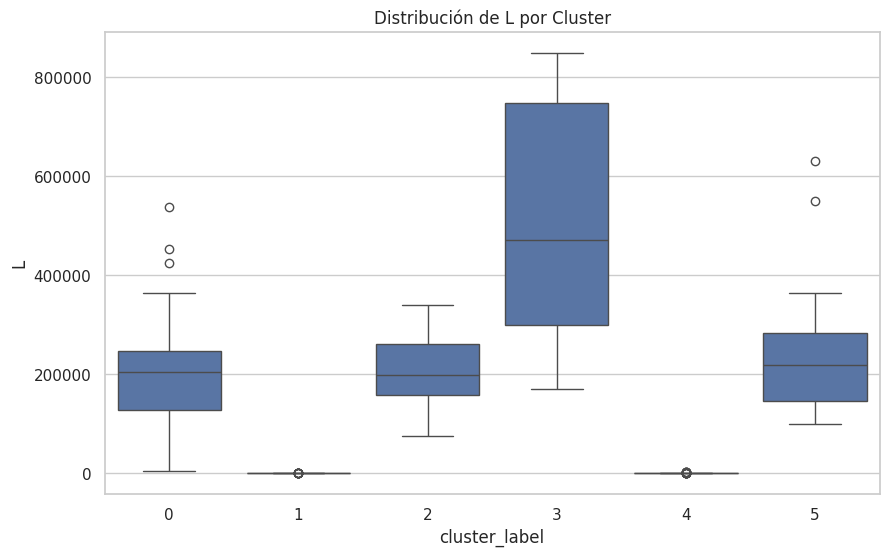

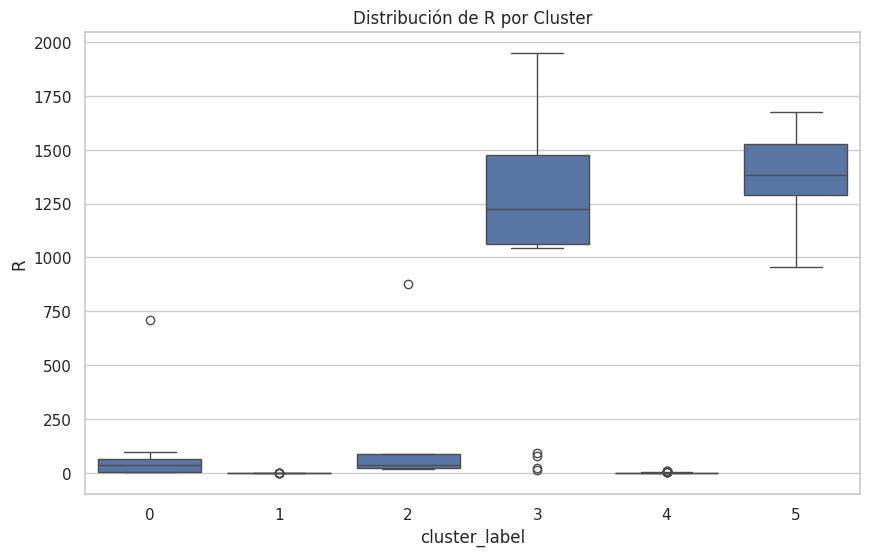

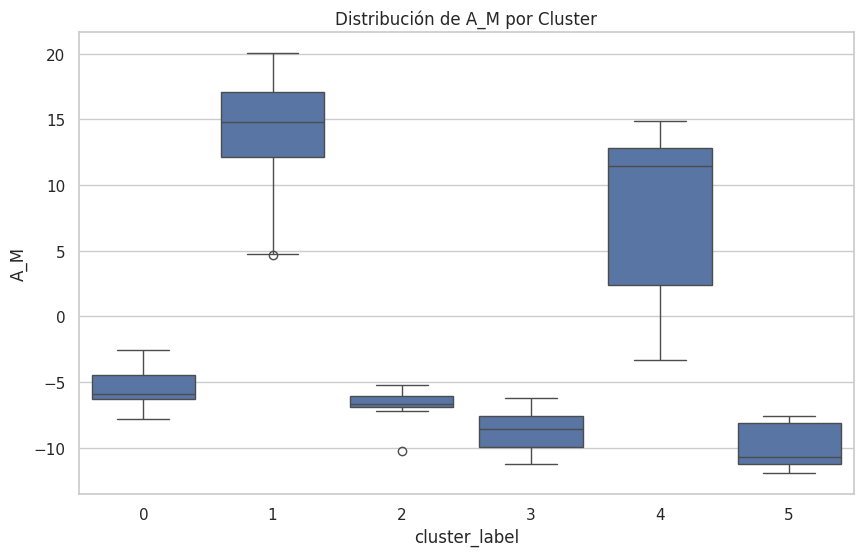

In [ ]:
import pandas as pd
import numpy as np

stars_data_encoded['cluster_label'] = kmeans.labels_

# Agrupar por etiqueta de cluster y calcular estadísticas
cluster_characteristics = stars_data_encoded.groupby('cluster_label').agg({
    'Temperature': ['mean', 'median', 'min', 'max'],
    'L': ['mean', 'median', 'min', 'max'],
    'R': ['mean', 'median', 'min', 'max'],
    'A_M': ['mean', 'median', 'min', 'max'],
    'Spectral_Class_encoded': lambda x: x.mode(),  # Moda de la clase espectral
    'Color_encoded': lambda x: x.mode()  # Moda del color
}).round(2)

print(cluster_characteristics)

import seaborn as sns
import matplotlib.pyplot as plt

for column in ['Temperature', 'L', 'R', 'A_M']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster_label', y=column, data=stars_data_encoded)
    plt.title(f'Distribución de {column} por Cluster')
    plt.show()



Como podemos observar en las gráficas:

**- En las variables categóricas:**

Los clusters muestran una agrupación distinta en términos de clase espectral y color, lo cual indica que el modelo ha identificado grupos con características espectrales y de coloración distintivas.
  
Por ejemplo, **el Cluster 1** se caracteriza por tener una mayoría de estrellas de clase espectral 'M', lo que generalmente indica estrellas más frías, y esto coincide con los colores predominantes como el rojo y el naranja.

**- Distribución de Luminosidad (L):**

La luminosidad varía significativamente entre los clusters, con algunos mostrando valores extremadamente altos (como el Cluster 3), que podrían corresponder a supergigantes o hipergigantes según la astronomía clásica, que son estrellas muy luminosas y grandes.

**- Distribución de la Magnitud Absoluta (A_M):**

La magnitud absoluta, que indica el brillo de una estrella a una distancia estándar, también muestra variaciones claras entre los clusters. El Cluster 3, por ejemplo, muestra valores muy bajos (más brillantes) en comparación con otros clusters.

**Distribución de la Temperatura:**

Los clusters también se diferencian en temperatura. El Cluster 0 tiene estrellas con temperaturas bajas, mientras que el Cluster 3 tiene estrellas con temperaturas más altas, lo que podría estar relacionado con estrellas más jóvenes y masivas como las estrellas en secuencia principal o estrellas de tipo B y A.

**En conclusión:**

Comparando con las categorías qconocidas de estrellas que nos dieron en el enunciado de la práctica, el modelo ha logrado capturar grupos que podrían corresponder a diferentes tipos de estrellas según la astronomía.







Ahora, agrupamos los datos por clusters en una tabla para mostrar la media en el caso de datos numéricos y la moda en los categóricos.

In [ ]:
stars_data_encoded['cluster'] = kmeans.labels_

# Revertir las codificaciones a las categorías originales
stars_data_encoded['Spectral_Class'] = decoded_df['Spectral_Class']
stars_data_encoded['Color'] = decoded_df['Color']

# Agrupar por etiqueta de cluster y calcular estadísticas para columnas numéricas
cluster_characteristics_numeric = stars_data_encoded.groupby('cluster').agg({
    'Temperature': ['mean'],
    'L': ['mean'],
    'R': ['mean'],
    'A_M': ['mean']
}).round(2)

cluster_characteristics_numeric.columns = ['Temp', 'L', 'R', 'A_M']

# Agrupar por etiqueta de cluster y obtener la moda para las características categóricas
cluster_characteristics_categorical = stars_data_encoded.groupby('cluster').agg({
    'Spectral_Class': lambda x: x.mode()[0],
    'Color': lambda x: x.mode()[0]
})

# Combinar las características numéricas y categóricas en un solo DataFrame
cluster_characteristics = pd.concat([cluster_characteristics_numeric, cluster_characteristics_categorical], axis=1)

print(cluster_characteristics)

             Temp          L        R    A_M Spectral_Class       Color
cluster                                                                
0        21793.36  203221.86    52.88  -5.55              O        Blue
1         3213.88       0.02     0.26  14.60              M         Red
2         3466.80  206600.00   129.50  -6.80              M         Red
3        24015.89  512365.61  1105.39  -8.73              O        Blue
4        12522.15     133.97     1.25   8.42              B  Blue-White
5         3782.38  245541.67  1391.88  -9.92              M         Red


**Cluster 0 y Cluster 3:**

- Temperatura: Ambos clusters presentan estrellas con temperaturas que corresponden a estrellas de tipo O (muy caliente), lo cual es congruente con la clasificación espectral O.
- Color: Azul, que es consistente con estrellas de alta temperatura.
- Clase Espectral: O.

**Cluster 1, Cluster 2 y Cluster 5:**

- Temperatura: Estos clusters incluyen estrellas con temperaturas bajas, que coinciden con la clase espectral M, común en estrellas enanas rojas y marrones.
- Color: Rojo, que es característico de estrellas más frías.
- Clase Espectral: M, alineado con las enanas rojas y marrones de la tabla.

**Cluster 4:**

- Temperatura: Alineada con las estrellas en secuencia principal o estrellas enanas blancas dada su temperatura relativamente alta.
- Color: Blanco-Azul, que sugiere una temperatura alta, posiblemente correspondiendo a estrellas tipo B-G.
- Clase Espectral: B, que corresponde a estrellas más calientes.

**Conclusión:**

Si bien el modelo ha categorizado las estrellas en clusters que reflejan algunas de las propiedades físicas esperadas basadas en las clases estelares conocidas, la distribución exacta de las características sugiere que mientras algunos clusters están bien alineados con tipos estelares específicos, otros pueden tener mezclas o no corresponder exactamente a las categorías tradicionales.

Lo que se me ocurre, es que al haber hecho PCA, este no toma en cuenta todos los datos, sino alrededor del 60-70%. Por lo tanto, puede ser que no haya tomado en cuenta la Luminosidad o el Radio.

Ya que como podemos ver, el cluster 2 aunque tiene una temperatura baja, tiene una luminosidad muy alta, cosa que no se corresponde a los datos reales que nos han proporcionado en el enunciado.

Finalmente, esta práctica ha sido muy buena para aprender sobre clustering y las diferentes técnicas para trabajar con datos.